In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *
from datetime import timedelta

## Load and Merge

In [2]:
data_folder = os.getcwd() + "/data/tourism"
samoa_folder = data_folder + "/samoa/"

In [3]:
samoa = (pd.read_csv(samoa_folder + "samoa_byCon.csv")
           .drop("Unnamed: 0", axis=1))

samoa["Date"] = pd.to_datetime(samoa["Date"])
samoa["Date"] = samoa["Date"] - timedelta(days=7)

samoa[["Year", "Month"]].groupby("Year").count()
samoa.head(5)

,Date,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0


In [4]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))
si_mean = covid_si.groupby("date").mean().reset_index()
si_mean["date"] = pd.to_datetime(si_mean["date"])

In [5]:
si_mean["year"], si_mean["month"] = si_mean["date"].dt.year, si_mean["date"].dt.month
si_mean = si_mean.groupby(["year", "month"]).mean().reset_index()
si_mean["date"] = [str(year) + "-" + str(month) for year, month in zip(si_mean.year, si_mean.month)]
si_mean["date"] = pd.to_datetime(si_mean["date"])
si_mean.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [6]:
samoa = (samoa.merge(si_mean, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"Total arrivals (persons)": "Total",
                  "stringency_index": "covid"}, axis=1))
samoa.head(5)

,Date,Total,American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month,year,month,covid
0,2002-08-01,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0,0.0,0.0
1,2002-09-01,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0,0.0,0.0
2,2002-10-01,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0,0.0,0.0
3,2002-11-01,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0,0.0,0.0
4,2002-12-01,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0,0.0,0.0


## Preprocessing

training size : 217, testing size : 25
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=683.569, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=690.968, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=650.182, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=609.110, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=688.990, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=608.613, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=608.483, Time=0.12 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=587.019, Time=0.42 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=578.666, Time=0.63 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=592.269, Time=0.41 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=580.764, Time=0.90 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=581.033, Time=0.87 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=640.674, Time=0.29 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=565.438, Time=0.7

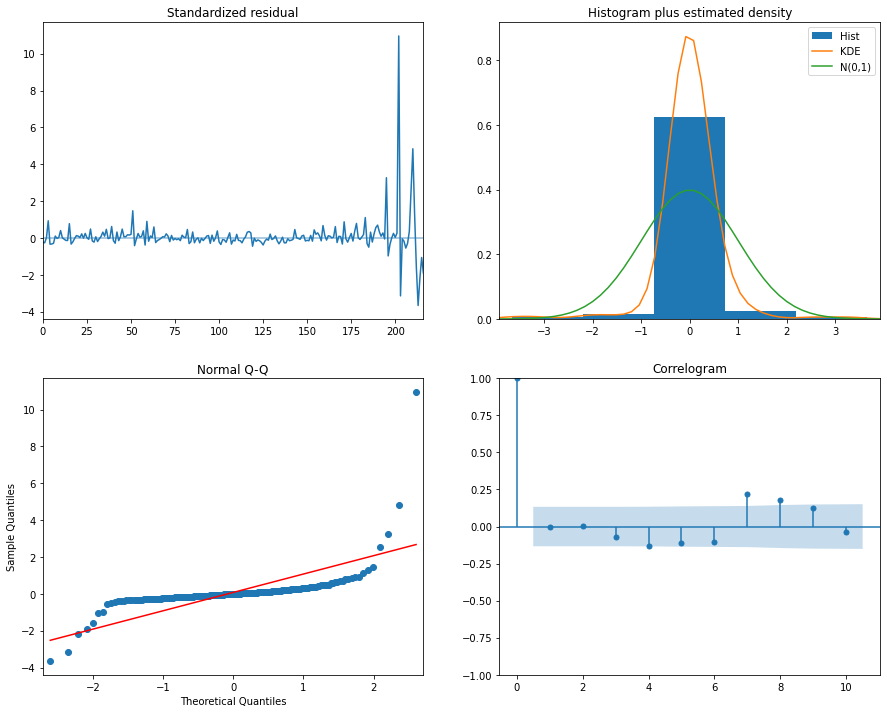

In [12]:
ss = SARIMAXPipeline(data=samoa, y_var="Total",
                     exog_var="covid", transform_method="scaledlogit")
ss.transform()
ss_sw = ss.stepwise_search()

In [8]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
ss.manual_search(all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:640.08
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:633.06
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:613.9
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:664.47
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:589.04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:568.51
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:628.69
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:611.05


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:595.9
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:577.05


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:568.66
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:565.75
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:599.3


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:596.81


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:595.78
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:566.83


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:568.82


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:567.72
Tried out SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:615.25
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:608.18
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:590.29
Tried out SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:651.76
Tried out SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:561.77


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 1)x(0, 1, 2, 12) - AIC:543.61
Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:604.23
Tried out SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:583.3


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:570.31
Tried out SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:551.75


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:543.23
Tried out SARIMAX(0, 0, 1)x(1, 1, 2, 12) - AIC:541.31
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:573.98


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:571.09
Tried out SARIMAX(0, 0, 1)x(2, 0, 2, 12) - AIC:570.89


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:541.89


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 1)x(2, 1, 1, 12) - AIC:543.83


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 1)x(2, 1, 2, 12) - AIC:543.31
Tried out SARIMAX(0, 0, 2)x(0, 0, 0, 12) - AIC:614.21
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:606.86
Tried out SARIMAX(0, 0, 2)x(0, 0, 2, 12) - AIC:587.67
Tried out SARIMAX(0, 0, 2)x(0, 1, 0, 12) - AIC:652.02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 2)x(0, 1, 1, 12) - AIC:556.91


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 2)x(0, 1, 2, 12) - AIC:539.56
Tried out SARIMAX(0, 0, 2)x(1, 0, 0, 12) - AIC:602.74
Tried out SARIMAX(0, 0, 2)x(1, 0, 1, 12) - AIC:579.08


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 0, 2)x(1, 0, 2, 12) - AIC:566.7
Tried out SARIMAX(0, 0, 2)x(1, 1, 0, 12) - AIC:547.42


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 2)x(1, 1, 1, 12) - AIC:538.32
Tried out SARIMAX(0, 0, 2)x(1, 1, 2, 12) - AIC:536.78
Tried out SARIMAX(0, 0, 2)x(2, 0, 0, 12) - AIC:570.25


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 2)x(2, 0, 1, 12) - AIC:566.71


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 2)x(2, 0, 2, 12) - AIC:566.78
Tried out SARIMAX(0, 0, 2)x(2, 1, 0, 12) - AIC:536.88


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 2)x(2, 1, 1, 12) - AIC:538.84


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 0, 2)x(2, 1, 2, 12) - AIC:538.76
Tried out SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC:686.67
Tried out SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC:679.36
Tried out SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC:660.76
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:730.53
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:618.2


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:605.44
Tried out SARIMAX(0, 1, 0)x(1, 0, 0, 12) - AIC:675.56
Tried out SARIMAX(0, 1, 0)x(1, 0, 1, 12) - AIC:645.44
Tried out SARIMAX(0, 1, 0)x(1, 0, 2, 12) - AIC:638.12
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:612.5


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:603.03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:602.76
Tried out SARIMAX(0, 1, 0)x(2, 0, 0, 12) - AIC:641.34


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 0)x(2, 0, 1, 12) - AIC:636.79


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 0)x(2, 0, 2, 12) - AIC:638.11
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:602.05
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:603.93


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:604.64
Tried out SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:604.59
Tried out SARIMAX(0, 1, 1)x(0, 0, 1, 12) - AIC:605.28


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 1, 1)x(0, 0, 2, 12) - AIC:587.89
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:680.64
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:567.14
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:550.79
Tried out SARIMAX(0, 1, 1)x(1, 0, 0, 12) - AIC:604.72
Tried out SARIMAX(0, 1, 1)x(1, 0, 1, 12) - AIC:583.66
Tried out SARIMAX(0, 1, 1)x(1, 0, 2, 12) - AIC:572.08
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:576.92


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:547.31


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:548.09


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:580.07


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(2, 0, 1, 12) - AIC:569.08


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(2, 0, 2, 12) - AIC:570.87
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:548.74


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:548.17


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:549.92
Tried out SARIMAX(0, 1, 2)x(0, 0, 0, 12) - AIC:596.64
Tried out SARIMAX(0, 1, 2)x(0, 0, 1, 12) - AIC:595.2
Tried out SARIMAX(0, 1, 2)x(0, 0, 2, 12) - AIC:578.82
Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 12) - AIC:655.26


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(0, 1, 2)x(0, 1, 1, 12) - AIC:552.35
Tried out SARIMAX(0, 1, 2)x(0, 1, 2, 12) - AIC:539.28
Tried out SARIMAX(0, 1, 2)x(1, 0, 0, 12) - AIC:593.73
Tried out SARIMAX(0, 1, 2)x(1, 0, 1, 12) - AIC:569.62
Tried out SARIMAX(0, 1, 2)x(1, 0, 2, 12) - AIC:561.9


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(1, 1, 0, 12) - AIC:551.78


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 12) - AIC:536.41


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(1, 1, 2, 12) - AIC:536.94


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(2, 0, 0, 12) - AIC:566.84


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(2, 0, 1, 12) - AIC:559.55


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(2, 0, 2, 12) - AIC:561.3
Tried out SARIMAX(0, 1, 2)x(2, 1, 0, 12) - AIC:536.43


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 2)x(2, 1, 1, 12) - AIC:550.15


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(0, 1, 2)x(2, 1, 2, 12) - AIC:538.79
Tried out SARIMAX(1, 0, 0)x(0, 0, 0, 12) - AIC:610.68
Tried out SARIMAX(1, 0, 0)x(0, 0, 1, 12) - AIC:604.17
Tried out SARIMAX(1, 0, 0)x(0, 0, 2, 12) - AIC:585.46
Tried out SARIMAX(1, 0, 0)x(0, 1, 0, 12) - AIC:651.68
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:555.39


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 0)x(0, 1, 2, 12) - AIC:538.89
Tried out SARIMAX(1, 0, 0)x(1, 0, 0, 12) - AIC:600.52
Tried out SARIMAX(1, 0, 0)x(1, 0, 1, 12) - AIC:576.96


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 0)x(1, 0, 2, 12) - AIC:565.3
Tried out SARIMAX(1, 0, 0)x(1, 1, 0, 12) - AIC:547.24


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 0)x(1, 1, 1, 12) - AIC:537.12
Tried out SARIMAX(1, 0, 0)x(1, 1, 2, 12) - AIC:536.03
Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:568.9


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 0)x(2, 0, 1, 12) - AIC:564.96
Tried out SARIMAX(1, 0, 0)x(2, 0, 2, 12) - AIC:565.39


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 0)x(2, 1, 0, 12) - AIC:535.87


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 0)x(2, 1, 1, 12) - AIC:537.76


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 0)x(2, 1, 2, 12) - AIC:537.99
Tried out SARIMAX(1, 0, 1)x(0, 0, 0, 12) - AIC:612.12
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:606.07
Tried out SARIMAX(1, 0, 1)x(0, 0, 2, 12) - AIC:587.22
Tried out SARIMAX(1, 0, 1)x(0, 1, 0, 12) - AIC:653.3


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 1)x(0, 1, 1, 12) - AIC:557.26


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 1)x(0, 1, 2, 12) - AIC:540.89
Tried out SARIMAX(1, 0, 1)x(1, 0, 0, 12) - AIC:602.49
Tried out SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC:578.73


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 1)x(1, 0, 2, 12) - AIC:567.27
Tried out SARIMAX(1, 0, 1)x(1, 1, 0, 12) - AIC:549.22


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 1)x(1, 1, 1, 12) - AIC:539.0
Tried out SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC:538.01


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:570.86
Tried out SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC:566.7


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 1)x(2, 0, 2, 12) - AIC:567.28
Tried out SARIMAX(1, 0, 1)x(2, 1, 0, 12) - AIC:537.77


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 1)x(2, 1, 1, 12) - AIC:539.64


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC:539.97
Tried out SARIMAX(1, 0, 2)x(0, 0, 0, 12) - AIC:600.06
Tried out SARIMAX(1, 0, 2)x(0, 0, 1, 12) - AIC:598.56


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 2)x(0, 0, 2, 12) - AIC:582.37
Tried out SARIMAX(1, 0, 2)x(0, 1, 0, 12) - AIC:652.28


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 2)x(0, 1, 1, 12) - AIC:552.47
Tried out SARIMAX(1, 0, 2)x(0, 1, 2, 12) - AIC:540.15
Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:604.2
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:580.04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:568.41


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:552.54


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:537.16


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:538.13


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:571.87
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:568.02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:568.51


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:537.3


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:538.48


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:540.41
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:657.85
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:649.93
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:631.22
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:684.94
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:590.85


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:579.71
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:645.46
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:616.34
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:610.48
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:586.59


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 0)x(1, 1, 1, 12) - AIC:576.89


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 0)x(1, 1, 2, 12) - AIC:577.58
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:612.9


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 0)x(2, 0, 1, 12) - AIC:608.16


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 0)x(2, 0, 2, 12) - AIC:609.91
Tried out SARIMAX(1, 1, 0)x(2, 1, 0, 12) - AIC:576.11
Tried out SARIMAX(1, 1, 0)x(2, 1, 1, 12) - AIC:577.94


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 0)x(2, 1, 2, 12) - AIC:579.44
Tried out SARIMAX(1, 1, 1)x(0, 0, 0, 12) - AIC:597.8
Tried out SARIMAX(1, 1, 1)x(0, 0, 1, 12) - AIC:596.16
Tried out SARIMAX(1, 1, 1)x(0, 0, 2, 12) - AIC:579.09
Tried out SARIMAX(1, 1, 1)x(0, 1, 0, 12) - AIC:683.18


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 1, 1)x(0, 1, 1, 12) - AIC:551.45
Tried out SARIMAX(1, 1, 1)x(0, 1, 2, 12) - AIC:538.74
Tried out SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:594.53
Tried out SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:569.19
Tried out SARIMAX(1, 1, 1)x(1, 0, 2, 12) - AIC:561.67


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:549.6


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:535.67


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(1, 1, 2, 12) - AIC:536.09


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(2, 0, 0, 12) - AIC:566.23


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(2, 0, 1, 12) - AIC:559.23


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 1)x(2, 0, 2, 12) - AIC:560.95


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 1)x(2, 1, 0, 12) - AIC:535.34
LU decomposition error.


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 1)x(2, 1, 2, 12) - AIC:537.94
Tried out SARIMAX(1, 1, 2)x(0, 0, 0, 12) - AIC:598.54
Tried out SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:597.19


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(0, 0, 2, 12) - AIC:580.65
Tried out SARIMAX(1, 1, 2)x(0, 1, 0, 12) - AIC:657.09


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(1, 1, 2)x(0, 1, 1, 12) - AIC:553.17
Tried out SARIMAX(1, 1, 2)x(0, 1, 2, 12) - AIC:540.4
Tried out SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:595.68
Tried out SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC:570.99


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 2)x(1, 0, 2, 12) - AIC:563.44
Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 12) - AIC:551.41


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC:537.45


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 12) - AIC:537.85


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 2)x(2, 0, 0, 12) - AIC:567.94


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(1, 1, 2)x(2, 0, 1, 12) - AIC:560.98


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC:564.65


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 0, 12) - AIC:537.2
LU decomposition error.


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC:539.7
Tried out SARIMAX(2, 0, 0)x(0, 0, 0, 12) - AIC:612.25
Tried out SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:606.06
Tried out SARIMAX(2, 0, 0)x(0, 0, 2, 12) - AIC:587.18
Tried out SARIMAX(2, 0, 0)x(0, 1, 0, 12) - AIC:652.34
Tried out SARIMAX(2, 0, 0)x(0, 1, 1, 12) - AIC:557.19


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 0, 0)x(0, 1, 2, 12) - AIC:540.89
Tried out SARIMAX(2, 0, 0)x(1, 0, 0, 12) - AIC:602.49
Tried out SARIMAX(2, 0, 0)x(1, 0, 1, 12) - AIC:578.66


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 0, 0)x(1, 0, 2, 12) - AIC:567.26
Tried out SARIMAX(2, 0, 0)x(1, 1, 0, 12) - AIC:549.19


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 0)x(1, 1, 1, 12) - AIC:538.94
Tried out SARIMAX(2, 0, 0)x(1, 1, 2, 12) - AIC:538.0


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 0)x(2, 0, 0, 12) - AIC:570.84
Tried out SARIMAX(2, 0, 0)x(2, 0, 1, 12) - AIC:566.62


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 0)x(2, 0, 2, 12) - AIC:567.22
Tried out SARIMAX(2, 0, 0)x(2, 1, 0, 12) - AIC:537.72


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 0)x(2, 1, 1, 12) - AIC:539.59


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 0)x(2, 1, 2, 12) - AIC:539.96
Tried out SARIMAX(2, 0, 1)x(0, 0, 0, 12) - AIC:601.17


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:608.06


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 0, 1)x(0, 0, 2, 12) - AIC:589.13
Tried out SARIMAX(2, 0, 1)x(0, 1, 0, 12) - AIC:642.81


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

Tried out SARIMAX(2, 0, 1)x(0, 1, 1, 12) - AIC:558.93


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 0, 1)x(0, 1, 2, 12) - AIC:542.64
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:604.46


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:580.53


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/cz

Tried out SARIMAX(2, 0, 1)x(1, 0, 2, 12) - AIC:569.11
Tried out SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:551.03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC:540.63


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:539.66


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:572.66


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

Tried out SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC:568.46


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC:569.05
Tried out SARIMAX(2, 0, 1)x(2, 1, 0, 12) - AIC:539.36


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:541.64


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC:541.63
Tried out SARIMAX(2, 0, 2)x(0, 0, 0, 12) - AIC:601.99


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

Tried out SARIMAX(2, 0, 2)x(0, 0, 1, 12) - AIC:600.58


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tried out SARIMAX(2, 0, 2)x(0, 0, 2, 12) - AIC:582.3


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:593.02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 0, 2)x(0, 1, 1, 12) - AIC:524.44


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:503.08


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:584.38


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

Tried out SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:557.63


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:549.98


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tried out SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:507.74


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Tried out SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:508.07


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:504.0


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czh

Tried out SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:541.65


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC:566.34


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:570.17


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:507.42


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:511.07


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:505.02
Tried out SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:644.03
Tried out SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:639.61
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:622.92
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:682.21


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:586.53
Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:575.02
Tried out SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:636.71
Tried out SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:610.05
Tried out SARIMAX(2, 1, 0)x(1, 0, 2, 12) - AIC:603.68
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:584.07


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 0)x(1, 1, 1, 12) - AIC:572.46


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:573.52
Tried out SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:607.5


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 0)x(2, 0, 1, 12) - AIC:601.62


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 0)x(2, 0, 2, 12) - AIC:603.54
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:572.2
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 12) - AIC:573.7


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 12) - AIC:575.41
Tried out SARIMAX(2, 1, 1)x(0, 0, 0, 12) - AIC:597.49
Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:596.23
Tried out SARIMAX(2, 1, 1)x(0, 0, 2, 12) - AIC:580.15
Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 12) - AIC:683.13


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 12) - AIC:552.79


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 12) - AIC:539.93
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:594.77
Tried out SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:570.44


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 1)x(1, 0, 2, 12) - AIC:562.84
Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 12) - AIC:551.11


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 12) - AIC:537.13


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 12) - AIC:537.53


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:567.58


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:560.67


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:562.38
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:536.89


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:552.0


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:540.9
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:599.41


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:597.93


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:582.14
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:665.14
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:555.99


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:542.69


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:596.27


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:572.5


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:565.51
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:552.81


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:539.66


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:540.09


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czh

Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:568.72


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:563.07


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:564.86


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:540.0


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:541.99


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:541.96


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14fc6e7c0>,
  640.0801447937033,
  ((0, 0, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159c97a60>,
  633.0634522983219,
  ((0, 0, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159bf08b0>,
  613.8988554941438,
  ((0, 0, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1598b3ee0>,
  664.4667774056063,
  ((0, 0, 0), (0, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159a70e50>,
  589.0360990209068,
  ((0, 0, 0), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159cdafa0>,
  568.5083067639821,
  ((0, 0, 0), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159d1fe20>,
  628.6856111407859,
  ((0, 0, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x159d50130>,
  611.0478428946938,

In [9]:
ss_msres = ss.manual_search_results
ss_msres.sort(key=lambda x: x[1])
ss_msres

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35af86490>,
  503.0811203938448,
  ((2, 0, 2), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35d9d99a0>,
  504.00256722474677,
  ((2, 0, 2), (1, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35da60fd0>,
  505.0217307160018,
  ((2, 0, 2), (2, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35da39d60>,
  507.4193289523607,
  ((2, 0, 2), (2, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35d99b490>,
  507.7371285468229,
  ((2, 0, 2), (1, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35d99b640>,
  508.0713031345424,
  ((2, 0, 2), (1, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35da399a0>,
  511.073295737098,
  ((2, 0, 2), (2, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x35d8ec3d0>,
  524.4378250081513,

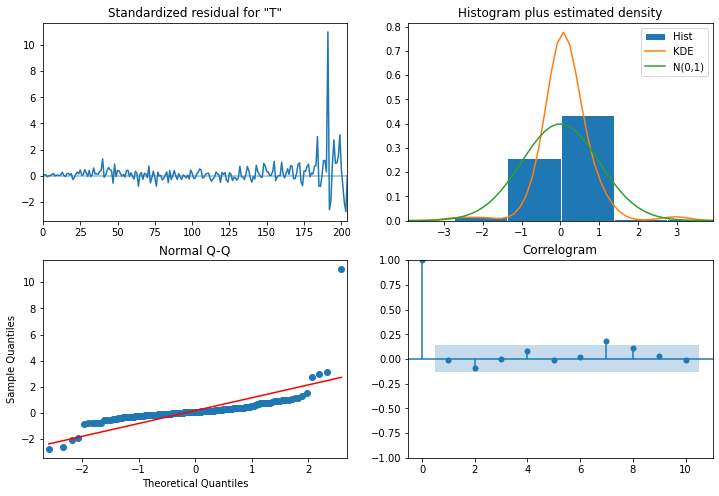

In [11]:
f = ss_msres[1][0].plot_diagnostics(figsize=(15,12))
plt.show()

In [19]:
ss_models = []
ss_models.append(pm.ARIMA(
    ss_sw["order"], ss_sw["seasonal_order"],  exog=ss.exog[:ss.training_size]))

for res in ss_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=ss.exog[:ss.training_size])
    ss_models.append(model)

In [20]:
ss.compare_models(ss.transformed_y[:ss.training_size], ss.exog[:ss.training_size], ss_models)

[CV] fold=0 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/U

[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=2 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=3 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=4 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=5 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=8 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=10 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=11 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=12 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=14 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=15 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=16 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=17 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=18 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=19 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=20 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=21 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=22 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=23 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=24 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


[CV] fold=25 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=26 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=27 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=28 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=29 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=30 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=31 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=32 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varian

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observatio

[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] fold=30 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=31 .........................................................
[CV] fold=32 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/states

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] fold=30 .........................................................
[CV] fold=31 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observatio

[CV] fold=32 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/mini

[CV] fold=29 .........................................................
[CV] fold=30 .........................................................
[CV] fold=31 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=32 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/mini

[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/mini

[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=30 .........................................................
[CV] fold=31 .........................................................
[CV] fold=32 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to 

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 1, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(0, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(2, 1, 0, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 0, 12))],
 'cv_scores': [array([ 20.54153949, 116.10895118,  73.15164315, 127.53762449,
          27.75487177, 180.77059046,  48.96464439, 191.21622085,
          96.51812163, 177.18719864,  78.28911124, 200.        ,
         164.83978616, 200.        ,  49.20974927, 187.01377085,
          67.55878921, 189.81959673, 178.48103646, 174.19267451,
          47.79041988, 160.7239685 ,  68.1977489 , 170.97130709,
          84.96484258, 174.39857478, 125.75700452, 167.50510673,
         127.67315919, 143.41911953,  95.68872106, 145.57435612,
         192.07742644]),
  array([ 15.82871829,  21.0246443 ,  24.02348851,  26.38282136,
          32.75372016,  35.9332

In [55]:
samoa_scaled.get_prediction_df(manual_search_results[1][0], 25, samoa_scaled.exog[-samoa_scaled.test_size:])

Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,0.000000,1000.030648,-1960.024054,1960.024054,NaN
1,-0.000026,1000.030647,-1960.024079,1960.024026,NaN
2,-0.000029,1000.030647,-1960.024082,1960.024023,NaN
3,0.000002,1000.030646,-1960.024047,1960.024052,NaN
4,0.000066,1000.030644,-1960.023980,1960.024113,NaN
...,...,...,...,...,...
238,NaN,0.936639,-10.605198,-6.933641,-8.769420
239,NaN,0.936645,-2.373358,1.298223,-0.537568
240,NaN,0.946529,-4.065393,-0.355067,-2.210230
241,NaN,0.961376,-5.770154,-2.001630,-3.885892


In [13]:
minmax_pred = get_prediction_df(minmax_res, test_size, test["covid"])
for col in minmax_pred.columns:
    inv_array = minmax.inverse_transform(minmax_pred[[col]].iloc[13:])
    minmax_pred[col] = pd.DataFrame(inv_array)
samoa_stats = pd.concat([samoa, minmax_pred], axis=1)
samoa_stats.head(5)

,Date,Total,American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month,year,month,covid,minmax,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2002-08-08,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0,0.0,0.0,0.335132,6885.000016,1985.431821,2993.625153,10776.374879,NaN
1,2002-09-08,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0,0.0,0.0,0.272163,6235.077217,1892.724096,2525.406155,9944.748278,NaN
2,2002-10-08,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0,0.0,0.0,0.232767,7318.069184,1852.223851,3687.777144,10948.361224,NaN
3,2002-11-08,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0,0.0,0.0,0.269931,13232.799292,1827.258217,9651.438997,16814.159587,NaN
4,2002-12-08,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0,0.0,0.0,0.529152,7573.751863,1806.028575,4034.000901,11113.502824,NaN


In [14]:
## Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

## list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

## Search the minimim aic 
all_res = sarimax(train["Total"], train["covid"], all_param)
all_res.sort(key=lambda x: x[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29327D+01    |proj g|=  6.04637D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.046D-06   1.293D+01
  F =   12.932679725539481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:5642.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.00919D+01    |proj g|=  3.06286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   1.006D-04   1.009D+01
  F =   10.090986159437087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:4407.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10512D+01    |proj g|=  1.96955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05664D+00    |proj g|=  6.17001D-02

At iterate    5    f=  9.01636D+00    |proj g|=  7.86313D-05

At iterate   10    f=  9.01636D+00    |proj g|=  1.17024D-03

At iterate   15    f=  9.01584D+00    |proj g|=  1.49061D-02

At iterate   20    f=  8.98956D+00    |proj g|=  5.67908D-02

At iterate   25    f=  8.98266D+00    |proj g|=  5.03739D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     27      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.55459D+00    |proj g|=  3.66205D-03

At iterate   15    f=  9.55441D+00    |proj g|=  3.33035D-04

At iterate   20    f=  9.55430D+00    |proj g|=  7.43679D-03

At iterate   25    f=  9.53962D+00    |proj g|=  5.39406D-02

At iterate   30    f=  9.52957D+00    |proj g|=  4.22228D-03

At iterate   35    f=  9.52257D+00    |proj g|=  2.23213D-02

At iterate   40    f=  9.52096D+00    |proj g|=  1.68049D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     51      1     0     0   1.680D-05   9.521D+00
  F =   9.5209621438144172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.98532D+00    |proj g|=  2.78851D-05

At iterate   10    f=  8.98532D+00    |proj g|=  1.35742D-03

At iterate   15    f=  8.98485D+00    |proj g|=  1.46532D-02

At iterate   20    f=  8.98271D+00    |proj g|=  1.44937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   2.510D-06   8.983D+00
  F =   8.9827057564480519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:3924.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  8.99799D+00    |proj g|=  9.84944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   5.944D-05   8.998D+00
  F =   8.9979897952013559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:3933.12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49834D+01    |proj g|=  1.11178D+01

At iterate    5    f=  9.56164D+00    |proj g|=  5.03839D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  9.53540D+00    |proj g|=  1.13074D-02

At iterate   20    f=  9.52847D+00    |proj g|=  1.86398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   4.722D-05   9.528D+00
  F =   9.5284227536844117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:4164.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95739D+01    |proj g|=  3.81919D+01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.54183D+00    |proj g|=  1.30079D-03

At iterate   25    f=  9.54111D+00    |proj g|=  1.89935D-03

At iterate   30    f=  9.53910D+00    |proj g|=  1.68083D-02

At iterate   35    f=  9.52949D+00    |proj g|=  6.39847D-03

At iterate   40    f=  9.52373D+00    |proj g|=  6.23929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     54      1     0     0   6.239D-04   9.524D+00
  F =   9.5237262914268435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:4164.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.


Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:3924.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03682D+00    |proj g|=  1.24653D-01

At iterate    5    f=  8.98425D+00    |proj g|=  1.50907D-02

At iterate   10    f=  8.98348D+00    |proj g|=  1.92950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.929D-05   8.983D+00
  F =   8.9834821774282094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:3926.8
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07192D+00    |proj g|=  6.74331D-02



 This problem is unconstrained.


At iterate    5    f=  8.99302D+00    |proj g|=  2.61955D-03

At iterate   10    f=  8.99299D+00    |proj g|=  1.57945D-04

At iterate   15    f=  8.99297D+00    |proj g|=  2.88212D-03

At iterate   20    f=  8.99250D+00    |proj g|=  5.11828D-03

At iterate   25    f=  8.99217D+00    |proj g|=  6.79118D-04

At iterate   30    f=  8.99203D+00    |proj g|=  7.08182D-03

At iterate   35    f=  8.99136D+00    |proj g|=  1.17637D-03

At iterate   40    f=  8.99132D+00    |proj g|=  8.09538D-04

At iterate   45    f=  8.98289D+00    |proj g|=  5.43805D-03

At iterate   50    f=  8.98223D+00    |proj g|=  5.89547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:3928.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04529D+01    |proj g|=  1.11303D-01

At iterate    5    f=  1.04256D+01    |proj g|=  6.32065D-05

At iterate   10    f=  1.04256D+01    |proj g|=  2.85105D-03

At iterate   15    f=  1.04206D+01    |proj g|=  3.75821D-02

At iterate   20    f=  1.02642D+01    |proj g|=  7.82466D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   5.259D-

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.03071D+01    |proj g|=  4.12372D-04

At iterate   10    f=  1.03071D+01    |proj g|=  5.18099D-04

At iterate   15    f=  1.03069D+01    |proj g|=  6.96444D-03

At iterate   20    f=  1.02889D+01    |proj g|=  4.86991D-02

At iterate   25    f=  9.62511D+00    |proj g|=  1.63603D-01

At iterate   30    f=  9.60415D+00    |proj g|=  2.03811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   2.023D-05   9.604D+00
  F =   9.6041508161902094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:4197

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.69168D+00    |proj g|=  4.11566D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     26      1     0     0   4.139D-08   8.689D+00
  F =   8.6886573726390850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:3796.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77761D+00    |proj g|=  5.34077D-02

At iterate    5    f=  8.75305D+00    |proj g|=  1.29749D-04


 This problem is unconstrained.



At iterate   10    f=  8.75304D+00    |proj g|=  1.42780D-03

At iterate   15    f=  8.75162D+00    |proj g|=  1.92146D-02

At iterate   20    f=  8.70271D+00    |proj g|=  8.57862D-02

At iterate   25    f=  8.68818D+00    |proj g|=  9.86947D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   1.556D-07   8.688D+00
  F =   8.6881754945290108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(0, 1, 2, 12) - AIC:3798.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:4057.41
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02943D+01    |proj g|=  3.25342D-02

At iterate    5    f=  1.02821D+01    |proj g|=  1.02855D-02

At iterate   10    f=  1.02807D+01    |proj g|=  8.46764D-05

At iterate   15    f=  1.02806D+01    |proj g|=  1.19013D-03

At iterate   20    f=  1.02690D+01    |proj g|=  2.80318D-02

At iterate   25    f=  9.49520D+00    |proj g|=  3.63039D-01

At iterate   30    f=  9.20698D+00    |proj g|=  4.30625D-02

At iterate   35    f=  9.20361D+00    |proj g|=  1.63051D-02

At iterate   40    f=  9.19756D+00    |proj g|=  9.59133D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

 This problem is unconstrained.



At iterate   25    f=  1.00782D+01    |proj g|=  4.35477D-01

At iterate   30    f=  9.67259D+00    |proj g|=  1.13952D-01

At iterate   35    f=  9.53289D+00    |proj g|=  2.29282D-02

At iterate   40    f=  9.53178D+00    |proj g|=  2.64905D-03

At iterate   45    f=  9.52938D+00    |proj g|=  3.25608D-03

At iterate   50    f=  9.52920D+00    |proj g|=  2.48012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   2.480D-03   9.529D+00
  F =   9.5291981281351035     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(1, 0, 2, 12) - AIC:4166

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  8.75904D+00    |proj g|=  9.28505D-03

At iterate   20    f=  8.73723D+00    |proj g|=  1.11821D-01

At iterate   25    f=  8.70101D+00    |proj g|=  4.03972D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   6.930D-07   8.701D+00
  F =   8.7010063580006172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:3801.64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.74066D+00    |proj g|=  1.59445D-02

At iterate   25    f=  8.68931D+00    |proj g|=  1.53217D-02

At iterate   30    f=  8.68815D+00    |proj g|=  8.73968D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   8.740D-07   8.688D+00
  F =   8.6881480308748067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:3798.03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  8.75298D+00    |proj g|=  9.31690D-04

At iterate   10    f=  8.75297D+00    |proj g|=  9.06671D-04

At iterate   15    f=  8.75285D+00    |proj g|=  1.15087D-03

At iterate   20    f=  8.75281D+00    |proj g|=  1.35755D-03

At iterate   25    f=  8.75260D+00    |proj g|=  3.75386D-03

At iterate   30    f=  8.75202D+00    |proj g|=  6.86852D-04

At iterate   35    f=  8.69411D+00    |proj g|=  2.70452D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     60      1     0     0   1.175D-04   8.689D+00
  F =   8.6886593094670506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tried out SARIMAX(0, 0, 1)x(1, 1, 2, 12) - AIC:3800.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04529D+01    |proj g|=  4.11488D-01

At iterate    5    f=  1.02827D+01    |proj g|=  4.50774D-03

At iterate   10    f=  1.02824D+01    |proj g|=  2.07204D-04

At iterate   15    f=  1.02824D+01    |proj g|=  1.57307D-03

At iterate   20    f=  1.02764D+01    |proj g|=  1.19251D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   25    f=  9.87505D+00    |proj g|=  2.54289D-03

At iterate   30    f=  9.86793D+00    |proj g|=  1.23531D-03
  ys=-5.928E-01  -gs= 1.660E-02 BFGS update SKIPPED

At iterate   35    f=  9.38550D+00    |proj g|=  2.64289D-01

At iterate   40    f=  9.22716D+00    |proj g|=  7.36197D-03

At iterate   45    f=  9.22618D+00    |proj g|=  4.35186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     76      1     1     0   6.057D-07   9.226D+00
  F =   9.2261839601465194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:4032.62
RUNNIN

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  1.02802D+01    |proj g|=  8.46557D-05

At iterate   25    f=  1.02802D+01    |proj g|=  1.05874D-03

At iterate   30    f=  1.02776D+01    |proj g|=  8.49557D-03

At iterate   35    f=  9.44013D+00    |proj g|=  1.47482D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     60      1     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  1.02806D+01    |proj g|=  1.29408D-03

At iterate   20    f=  1.02804D+01    |proj g|=  2.56110D-03

At iterate   25    f=  1.02799D+01    |proj g|=  6.56446D-04

At iterate   30    f=  1.02797D+01    |proj g|=  7.37520D-04

At iterate   35    f=  1.02792D+01    |proj g|=  2.77108D-03

At iterate   40    f=  1.02336D+01    |proj g|=  4.32514D-02
  ys=-1.085E-01  -gs= 3.595E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     54      1     1     0   4.325D-02   1.023D+01
  F =   10.233587854946459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate   15    f=  8.74996D+00    |proj g|=  3.15591D-02

At iterate   20    f=  8.69366D+00    |proj g|=  2.59155D-02

At iterate   25    f=  8.69144D+00    |proj g|=  1.36366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   6.862D-07   8.691D+00
  F =   8.6914384265590936     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:3799.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.75299D+00    |proj g|=  8.63884D-04

At iterate   20    f=  8.74843D+00    |proj g|=  2.26230D-02

At iterate   25    f=  8.70702D+00    |proj g|=  8.43790D-03

At iterate   30    f=  8.69987D+00    |proj g|=  8.79011D-03

At iterate   35    f=  8.69338D+00    |proj g|=  5.92546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   1.109D-04   8.693D+00
  F =   8.6933723260028994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(2, 1, 1, 12) - AIC:3802.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.75285D+00    |proj g|=  3.61550D-04

At iterate   15    f=  8.75278D+00    |proj g|=  5.71399D-03

At iterate   20    f=  8.75198D+00    |proj g|=  1.70863D-03

At iterate   25    f=  8.71106D+00    |proj g|=  4.93481D-02

At iterate   30    f=  8.68815D+00    |proj g|=  1.19895D-03

At iterate   35    f=  8.68815D+00    |proj g|=  5.61585D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     54      1     0     0   5.616D-05   8.688D+00
  F =   8.6881496634646442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(2, 1, 2, 12) - AIC:3802

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   30    f=  9.73579D+00    |proj g|=  9.68704D-03

At iterate   35    f=  9.68100D+00    |proj g|=  2.09480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     61      1     0     0   2.112D-05   9.681D+00
  F =   9.6809883956711058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:4230.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03238D+01    |proj g|=  4.62618D-02

At iterate    

 This problem is unconstrained.



At iterate   20    f=  1.02589D+01    |proj g|=  3.91986D-02

At iterate   25    f=  9.86334D+00    |proj g|=  3.88208D-01

At iterate   30    f=  9.52564D+00    |proj g|=  1.77266D-01

At iterate   35    f=  9.47048D+00    |proj g|=  2.89089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     59      1     0     0   1.053D-04   9.470D+00
  F =   9.4704715546947007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(0, 0, 2, 12) - AIC:4141.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.68778D+00    |proj g|=  2.28341D-02

At iterate   25    f=  8.66486D+00    |proj g|=  1.17922D-01

At iterate   30    f=  8.65457D+00    |proj g|=  9.36318D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     35      1     0     0   9.363D-06   8.655D+00
  F =   8.6545677485974295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(0, 1, 0, 12) - AIC:3781.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  8.64719D+00    |proj g|=  3.57706D-02

At iterate   10    f=  8.63808D+00    |proj g|=  5.60173D-03

At iterate   15    f=  8.63801D+00    |proj g|=  2.51109D-04

At iterate   20    f=  8.63792D+00    |proj g|=  5.25892D-03

At iterate   25    f=  8.62660D+00    |proj g|=  5.89414D-02

At iterate   30    f=  8.56819D+00    |proj g|=  5.06969D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     37      1     0     0   3.017D-05   8.568D+00
  F =   8.5681605846588642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(0, 1, 2, 12) - AIC:3747

 This problem is unconstrained.



At iterate   40    f=  9.17464D+00    |proj g|=  6.98489D-02

At iterate   45    f=  9.16880D+00    |proj g|=  8.05850D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     78      1     0     0   1.991D-06   9.169D+00
  F =   9.1688004470929503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(1, 0, 0, 12) - AIC:4007.6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02982D+01    |proj g|=  3.37759D-02

At iterate    5

 This problem is unconstrained.



At iterate   25    f=  1.00163D+01    |proj g|=  5.22769D-02

At iterate   30    f=  9.71690D+00    |proj g|=  4.26221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     72      1     0     0   4.623D-02   9.189D+00
  F =   9.1888421355341787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(1, 0, 1, 12) - AIC:4018.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02969D+01    |proj g|=  4.68709D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.02805D+01    |proj g|=  2.90118D-03

At iterate   10    f=  1.02788D+01    |proj g|=  3.11419D-03

At iterate   15    f=  1.02787D+01    |proj g|=  1.50759D-04

At iterate   20    f=  1.02787D+01    |proj g|=  2.73144D-03

At iterate   25    f=  1.02678D+01    |proj g|=  4.86074D-02

At iterate   30    f=  9.74660D+00    |proj g|=  2.21361D-01

At iterate   35    f=  9.68194D+00    |proj g|=  1.04471D-02

At iterate   40    f=  9.44008D+00    |proj g|=  1.37262D-01

At iterate   45    f=  9.07328D+00    |proj g|=  2.17708D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.07268D+00    |proj g|=  6.38337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   6.383D-04   9.073D+00
  F =   9.0726788450127440     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(1, 0, 2, 12) - AIC:3969.69
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87389D+00    |proj g|=  7.73028D-01

At iterate    5    f=  8.68221D+00    |proj g|=  7.69585D-02

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  8.63782D+00    |proj g|=  2.06855D-03

At iterate   20    f=  8.63440D+00    |proj g|=  3.54182D-02

At iterate   25    f=  8.57054D+00    |proj g|=  3.08837D-02

At iterate   30    f=  8.56795D+00    |proj g|=  1.65164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   8.489D-06   8.568D+00
  F =   8.5679471727711256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(1, 1, 1, 12) - AIC:3747.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  8.63818D+00    |proj g|=  7.96369D-03

At iterate   15    f=  8.63791D+00    |proj g|=  4.67875D-04

At iterate   20    f=  8.63779D+00    |proj g|=  5.02920D-03

At iterate   25    f=  8.63765D+00    |proj g|=  4.89181D-04

At iterate   30    f=  8.63765D+00    |proj g|=  3.61566D-04

At iterate   35    f=  8.63752D+00    |proj g|=  2.75686D-03

At iterate   40    f=  8.63105D+00    |proj g|=  2.47082D-02

At iterate   45    f=  8.56937D+00    |proj g|=  1.22441D-02

At iterate   50    f=  8.56900D+00    |proj g|=  5.99067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 2)x(1, 1, 2, 12) - AIC:3750.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04238D+01    |proj g|=  3.44213D-01

At iterate    5    f=  1.02808D+01    |proj g|=  3.04338D-03

At iterate   10    f=  1.02807D+01    |proj g|=  2.86643D-04

At iterate   15    f=  1.02805D+01    |proj g|=  2.96425D-03

At iterate   20    f=  1.02653D+01    |proj g|=  2.15584D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


LU decomposition error.  ys=-4.527E+09  -gs= 4.558E+00 BFGS update SKIPPED

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04889D+01    |proj g|=  5.34306D-01

At iterate    5    f=  1.02818D+01    |proj g|=  1.69076D-03

At iterate   10    f=  1.02807D+01    |proj g|=  8.51265D-03

At iterate   15    f=  1.02787D+01    |proj g|=  1.36631D-03


 This problem is unconstrained.



At iterate   20    f=  1.02786D+01    |proj g|=  8.50900D-05

At iterate   25    f=  1.02785D+01    |proj g|=  2.61182D-03

At iterate   30    f=  1.02413D+01    |proj g|=  2.63484D-02

At iterate   35    f=  9.71031D+00    |proj g|=  1.22452D-02

At iterate   40    f=  9.70141D+00    |proj g|=  1.00445D-02

At iterate   45    f=  9.67677D+00    |proj g|=  6.12058D-02

At iterate   50    f=  9.67351D+00    |proj g|=  2.99741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   2.997D-02   9.674D+00
  F =   9.6735079439179685     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  1.02792D+01    |proj g|=  4.30278D-03

At iterate   10    f=  1.02790D+01    |proj g|=  1.06287D-04

At iterate   15    f=  1.02789D+01    |proj g|=  2.22645D-03

At iterate   20    f=  1.02787D+01    |proj g|=  3.44018D-03

At iterate   25    f=  1.02782D+01    |proj g|=  1.51820D-03

At iterate   30    f=  1.02781D+01    |proj g|=  1.45643D-03

At iterate   35    f=  1.02770D+01    |proj g|=  2.45463D-03

At iterate   40    f=  1.02653D+01    |proj g|=  9.71879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     62      1     0     0   9.719D-03   1.027D+01
  F =   10.2653293823


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.63950D+00    |proj g|=  1.47953D-04

At iterate   15    f=  8.63948D+00    |proj g|=  1.81108D-03

At iterate   20    f=  8.63726D+00    |proj g|=  2.20048D-02

At iterate   25    f=  8.58068D+00    |proj g|=  6.93530D-02

At iterate   30    f=  8.57220D+00    |proj g|=  9.43208D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   3.077D-05   8.572D+00
  F =   8.5721988654482697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(2, 1, 0, 12) - AIC:3749.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  8.63763D+00    |proj g|=  1.17208D-03

At iterate   20    f=  8.63762D+00    |proj g|=  2.69229D-04

At iterate   25    f=  8.63747D+00    |proj g|=  5.42944D-03

At iterate   30    f=  8.62357D+00    |proj g|=  4.74691D-02

At iterate   35    f=  8.57916D+00    |proj g|=  2.93126D-03

At iterate   40    f=  8.57599D+00    |proj g|=  4.01305D-02

At iterate   45    f=  8.57428D+00    |proj g|=  3.39060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     62      1     0     0   1.567D-05   8.574D+00
  F =   8.5742752692350841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.66554D+00    |proj g|=  1.19283D-01

At iterate   10    f=  8.64249D+00    |proj g|=  4.50199D-02

At iterate   15    f=  8.63768D+00    |proj g|=  9.96060D-04

At iterate   20    f=  8.63767D+00    |proj g|=  7.35534D-04

At iterate   25    f=  8.63749D+00    |proj g|=  6.38448D-03

At iterate   30    f=  8.63616D+00    |proj g|=  1.97850D-02

At iterate   35    f=  8.58268D+00    |proj g|=  6.15875D-02

At iterate   40    f=  8.56796D+00    |proj g|=  2.19171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     65      1     0     0   9.183D-05   8.568D+00
  F =   8.56795050873

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  9.20107D+00    |proj g|=  1.43876D-01

At iterate   25    f=  9.13304D+00    |proj g|=  3.28503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   6.160D-06   9.133D+00
  F =   9.1330391826886537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC:3990.01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04891D+01    |proj g|=  3.36579D-05
  ys=-3.741E+00

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.30359D+00    |proj g|=  3.86935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   9.914D-06   8.300D+00
  F =   8.2998660024575415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:3624.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34196D+00    |proj g|=  1.32840D-01

At iterate    5    f=  8.32523D+00    |proj g|=  1.39982D-04

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.86810D+00    |proj g|=  5.85331D-02

At iterate   10    f=  8.84912D+00    |proj g|=  5.07811D-03

At iterate   15    f=  8.84885D+00    |proj g|=  9.91164D-05

At iterate   20    f=  8.84881D+00    |proj g|=  3.42576D-03

At iterate   25    f=  8.84211D+00    |proj g|=  6.37902D-03

At iterate   30    f=  8.83872D+00    |proj g|=  3.31859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   8.656D-07   8.839D+00
  F =   8.8387164547583783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 0, 2, 12) - AIC:3863

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.30209D+00    |proj g|=  1.55464D-02

At iterate   20    f=  8.29983D+00    |proj g|=  4.68834D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   4.688D-06   8.300D+00
  F =   8.2998336616419959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:3626.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34142D+00    |proj g|=  1.70440D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.29740D+00    |proj g|=  9.23909D-03

At iterate   15    f=  8.29529D+00    |proj g|=  3.68259D-03

At iterate   20    f=  8.29420D+00    |proj g|=  3.34595D-03

At iterate   25    f=  8.29406D+00    |proj g|=  6.26549D-04

At iterate   30    f=  8.29302D+00    |proj g|=  2.62325D-03

At iterate   35    f=  8.29072D+00    |proj g|=  1.80440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     40      1     0     0   8.211D-06   8.291D+00
  F =   8.2907188278384290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:3624

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.84260D+00    |proj g|=  3.60961D-04

At iterate   15    f=  8.84260D+00    |proj g|=  6.47562D-04

At iterate   20    f=  8.84210D+00    |proj g|=  7.79598D-03

At iterate   25    f=  8.83879D+00    |proj g|=  5.48553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   2.045D-05   8.839D+00
  F =   8.8386152017951503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(2, 0, 1, 12) - AIC:3863.64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  8.83686D+00    |proj g|=  6.02077D-03

At iterate   10    f=  8.83670D+00    |proj g|=  2.72586D-04

At iterate   15    f=  8.83660D+00    |proj g|=  5.62813D-03

At iterate   20    f=  8.83635D+00    |proj g|=  2.16641D-03

At iterate   25    f=  8.83600D+00    |proj g|=  1.80466D-03

At iterate   30    f=  8.83575D+00    |proj g|=  2.33095D-03

At iterate   35    f=  8.83570D+00    |proj g|=  1.92484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     46      1     0     0   2.991D-05   8.836D+00
  F =   8.8356988079199326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.31724D+00    |proj g|=  3.50324D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   3.503D-05   8.317D+00
  F =   8.3172446300448435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:3634.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32541D+00    |proj g|=  7.48223D-02

At iterate    5    f=  8.31556D+00    |proj g|=  6.30357D-02

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  8.30132D+00    |proj g|=  1.10776D-04

At iterate   20    f=  8.30128D+00    |proj g|=  2.58078D-03

At iterate   25    f=  8.29951D+00    |proj g|=  1.66105D-02

At iterate   30    f=  8.29560D+00    |proj g|=  7.32862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   1.116D-06   8.296D+00
  F =   8.2955974025663526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:3626.88
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.29646D+00    |proj g|=  1.63359D-02

At iterate   15    f=  8.29490D+00    |proj g|=  1.05942D-02

At iterate   20    f=  8.29343D+00    |proj g|=  1.26377D-03

At iterate   25    f=  8.29325D+00    |proj g|=  1.67829D-04

At iterate   30    f=  8.29325D+00    |proj g|=  6.91479D-05

At iterate   35    f=  8.29323D+00    |proj g|=  7.09403D-04

At iterate   40    f=  8.29154D+00    |proj g|=  9.61041D-03

At iterate   45    f=  8.29005D+00    |proj g|=  4.58687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     60      1     0     0   2.750D-06   8.290D+00
  F =   8.29004541192

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.19737D+00    |proj g|=  3.25321D-03

At iterate   15    f=  9.19349D+00    |proj g|=  3.68606D-02

At iterate   20    f=  9.10372D+00    |proj g|=  1.21482D-01

At iterate   25    f=  9.05778D+00    |proj g|=  1.09751D-01

At iterate   30    f=  9.04004D+00    |proj g|=  3.10135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   1.904D-06   9.040D+00
  F =   9.0400408430253254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 0, 2, 12) - AIC:3951.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.24763D+00    |proj g|=  1.44551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   2.213D-06   8.248D+00
  F =   8.2476278126238771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:3603.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29036D+00    |proj g|=  1.09851D-01

At iterate    5    f=  8.26994D+00    |proj g|=  1.41564D-04


 This problem is unconstrained.



At iterate   10    f=  8.26993D+00    |proj g|=  1.52687D-03

At iterate   15    f=  8.26869D+00    |proj g|=  1.78590D-02

At iterate   20    f=  8.24930D+00    |proj g|=  3.75386D-02

At iterate   25    f=  8.24754D+00    |proj g|=  1.77231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   9.239D-07   8.248D+00
  F =   8.2475430092289752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:3605.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.80790D+00    |proj g|=  2.85345D-02

At iterate   30    f=  8.80583D+00    |proj g|=  2.00070D-02

At iterate   35    f=  8.78625D+00    |proj g|=  1.83892D-02

At iterate   40    f=  8.78410D+00    |proj g|=  5.69274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     53      1     0     0   6.692D-06   8.784D+00
  F =   8.7840980799838349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(1, 0, 1, 12) - AIC:3839.87
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  9.12740D+00    |proj g|=  2.25705D-04

At iterate   15    f=  9.12732D+00    |proj g|=  2.41945D-03

At iterate   20    f=  9.12346D+00    |proj g|=  4.00439D-03

At iterate   25    f=  9.03571D+00    |proj g|=  4.85782D-02

At iterate   30    f=  8.82975D+00    |proj g|=  3.06849D-02

At iterate   35    f=  8.80906D+00    |proj g|=  1.37689D-02

At iterate   40    f=  8.80896D+00    |proj g|=  5.96309D-04
  ys=-1.177E-05  -gs= 8.612E-06 BFGS update SKIPPED

At iterate   45    f=  8.80896D+00    |proj g|=  9.90302D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     87      2     1     0   1.098D-04   8.809D+00
  F =   8.8089539520131570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(1, 0, 2, 12) - AIC:3852.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30105D+00    |proj g|=  9.10643D-02

At iterate    5    f=  8.28862D+00    |proj g|=  3.03798D-04

At iterate   10    f=  8.28860D+00    |proj g|=  2.16367D-03

At iterate   15

 This problem is unconstrained.



At iterate   25    f=  8.24753D+00    |proj g|=  2.61021D-03

At iterate   30    f=  8.24751D+00    |proj g|=  6.76206D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   6.762D-06   8.248D+00
  F =   8.2475076064463959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:3605.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30366D+00    |proj g|=  1.10696D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.26723D+00    |proj g|=  1.01248D-02

At iterate   15    f=  8.26560D+00    |proj g|=  1.05537D-02

At iterate   20    f=  8.26537D+00    |proj g|=  7.12587D-04

At iterate   25    f=  8.26536D+00    |proj g|=  3.63508D-04

At iterate   30    f=  8.26515D+00    |proj g|=  1.02562D-03

At iterate   35    f=  8.24752D+00    |proj g|=  6.06345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     57      1     0     0   1.605D-04   8.248D+00
  F =   8.2475209393029196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:3607.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16652D+00    |proj g|=  4.93232D-02

At iterate    5    f=  9.13362D+00    |proj g|=  1.81026D-02

At iterate   10    f=  9.13239D+00    |proj g|=  3.39964D-04

At iterate   15    f=  9.13225D+00    |proj g|=  7.44016D-03

At iterate   20    f=  9.11502D+00    |proj g|=  9.33091D-02


 This problem is unconstrained.



At iterate   25    f=  8.82991D+00    |proj g|=  2.04478D-02

At iterate   30    f=  8.81115D+00    |proj g|=  1.54812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     40      1     0     0   8.575D-06   8.811D+00
  F =   8.8111436038309776     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:3851.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16478D+00    |proj g|=  5.07961D-02

At iterate    

 This problem is unconstrained.



At iterate   15    f=  9.12640D+00    |proj g|=  5.89982D-03

At iterate   20    f=  8.98154D+00    |proj g|=  2.20718D-01

At iterate   25    f=  8.89040D+00    |proj g|=  3.26634D-02

At iterate   30    f=  8.87954D+00    |proj g|=  3.10240D-02

At iterate   35    f=  8.87529D+00    |proj g|=  1.58169D-04

At iterate   40    f=  8.87510D+00    |proj g|=  9.72568D-03

At iterate   45    f=  8.86401D+00    |proj g|=  6.02054D-02

At iterate   50    f=  8.81390D+00    |proj g|=  8.25043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     79      1     0     0   8.250D-02   8.814D+00
  F =   8.81390116170

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.12730D+00    |proj g|=  6.41094D-04

At iterate   15    f=  9.12697D+00    |proj g|=  3.59295D-03

At iterate   20    f=  9.12659D+00    |proj g|=  3.83132D-03

At iterate   25    f=  9.12613D+00    |proj g|=  1.25258D-03

At iterate   30    f=  9.12538D+00    |proj g|=  3.40018D-03

At iterate   35    f=  8.99445D+00    |proj g|=  1.47866D-01
  ys=-3.595E-05  -gs= 1.152E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  8.96021D+00    |proj g|=  1.11303D-02

At iterate   45    f=  8.96003D+00    |proj g|=  1.19919D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45    110      2     1     0   1.199D-02   8.960D+00
  F =   8.9600260547857218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 0, 2, 12) - AIC:3920.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29034D+00    |proj g|=  9.60558D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.27883D+00    |proj g|=  1.73159D-03

At iterate   15    f=  8.27806D+00    |proj g|=  2.15050D-02

At iterate   20    f=  8.26351D+00    |proj g|=  4.03441D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   2.042D-06   8.262D+00
  F =   8.2617225219592889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:3612.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.26794D+00    |proj g|=  1.24704D-03

At iterate   15    f=  8.26793D+00    |proj g|=  5.63915D-04

At iterate   20    f=  8.26771D+00    |proj g|=  9.00018D-03

At iterate   25    f=  8.25642D+00    |proj g|=  2.86331D-02

At iterate   30    f=  8.25179D+00    |proj g|=  3.09160D-03

At iterate   35    f=  8.24445D+00    |proj g|=  1.08346D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     50      1     0     0   7.072D-06   8.244D+00
  F =   8.2444519831684318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:3606

 This problem is unconstrained.



At iterate   10    f=  8.26776D+00    |proj g|=  4.18796D-03

At iterate   15    f=  8.26646D+00    |proj g|=  4.76100D-03

At iterate   20    f=  8.26582D+00    |proj g|=  7.56747D-03

At iterate   25    f=  8.26527D+00    |proj g|=  1.14402D-03

At iterate   30    f=  8.26526D+00    |proj g|=  4.83241D-04

At iterate   35    f=  8.26509D+00    |proj g|=  3.05827D-03

At iterate   40    f=  8.24589D+00    |proj g|=  7.42963D-03

At iterate   45    f=  8.24437D+00    |proj g|=  1.40411D-02

At iterate   50    f=  8.23875D+00    |proj g|=  3.05462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:3606.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42387D+00    |proj g|=  2.95283D-02

At iterate    5    f=  9.42079D+00    |proj g|=  2.25228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   1.909D-06   9.421D+00
  F =   9.4207915981403794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(0, 0, 0, 12) - AIC:4115.47
RUNNING THE L-BFGS-B CO

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.16879D+00    |proj g|=  5.59263D-04

At iterate   10    f=  9.16879D+00    |proj g|=  6.03197D-04

At iterate   15    f=  9.16835D+00    |proj g|=  9.52893D-03

At iterate   20    f=  9.11862D+00    |proj g|=  6.75447D-02

At iterate   25    f=  9.08626D+00    |proj g|=  8.83491D-02

At iterate   30    f=  9.03958D+00    |proj g|=  1.50104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     42      1     0     0   1.251D-06   9.039D+00
  F =   9.0392425855204710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(0, 0, 2, 12) - AIC:3953

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 12) - AIC:3659.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27936D+00    |proj g|=  5.12092D-02

At iterate    5    f=  8.27210D+00    |proj g|=  1.27692D-03

At iterate   10    f=  8.27210D+00    |proj g|=  7.78125D-04

At iterate   15    f=  8.27158D+00    |proj g|=  1.22290D-02

At iterate   20    f=  8.25393D+00    |proj g|=  9.60161D-02

At iterate   25    f=  8.24439D+00    |proj g|=  4.01301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     P

 This problem is unconstrained.



At iterate   10    f=  8.27188D+00    |proj g|=  9.74575D-04

At iterate   15    f=  8.27154D+00    |proj g|=  1.35574D-02

At iterate   20    f=  8.25187D+00    |proj g|=  5.19275D-02

At iterate   25    f=  8.24426D+00    |proj g|=  1.14846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   1.493D-06   8.244D+00
  F =   8.2442567871787951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(0, 1, 2, 12) - AIC:3606.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  9.08300D+00    |proj g|=  4.65525D-02

At iterate   25    f=  8.89672D+00    |proj g|=  2.61664D-01

At iterate   30    f=  8.79381D+00    |proj g|=  1.33436D-02

At iterate   35    f=  8.79201D+00    |proj g|=  3.57061D-02

At iterate   40    f=  8.78183D+00    |proj g|=  6.56247D-03

At iterate   45    f=  8.78170D+00    |proj g|=  9.78119D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58      1     0     0   1.186D-05   8.782D+00
  F =   8.7817003029219158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(1, 0, 1, 12) - AIC:3840

 This problem is unconstrained.



At iterate    5    f=  9.09253D+00    |proj g|=  2.89670D-03

At iterate   10    f=  9.09145D+00    |proj g|=  2.29917D-04

At iterate   15    f=  9.09142D+00    |proj g|=  1.99136D-03

At iterate   20    f=  9.08788D+00    |proj g|=  1.96814D-02

At iterate   25    f=  8.94055D+00    |proj g|=  1.94183D-01

At iterate   30    f=  8.85884D+00    |proj g|=  5.86578D-02

At iterate   35    f=  8.82053D+00    |proj g|=  7.69416D-03

At iterate   40    f=  8.81903D+00    |proj g|=  3.00540D-03

At iterate   45    f=  8.81862D+00    |proj g|=  1.39343D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.81355D+00    |proj g|=  3.37005D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   3.370D-02   8.814D+00
  F =   8.8135486322460110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(1, 0, 2, 12) - AIC:3856.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29690D+00    |proj g|=  4.30458D-02

At iterate    5    f=  8.28915D+00    |proj g|=  1.35137D-04

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  8.27158D+00    |proj g|=  1.15816D-02

At iterate   20    f=  8.25888D+00    |proj g|=  6.07659D-02

At iterate   25    f=  8.24421D+00    |proj g|=  9.69046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   1.579D-06   8.244D+00
  F =   8.2442005845052435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 12) - AIC:3606.47


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30004D+00    |proj g|=  1.06912D-01

At iterate    5    f=  8.27041D+00    |proj g|=  8.10923D-04

At iterate   10    f=  8.26987D+00    |proj g|=  7.82745D-03

At iterate   15    f=  8.26756D+00    |proj g|=  4.09287D-03

At iterate   20    f=  8.26718D+00    |proj g|=  5.75136D-04

At iterate   25    f=  8.26715D+00    |proj g|=  7.52304D-04

At iterate   30    f=  8.26633D+00    |proj g|=  1.17705D-02

At iterate   35    f=  8.24436D+00    |proj g|=  6.72152D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f=  8.24428D+00    |proj g|=  1.56038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     55      1     0     0   1.560D-04   8.244D+00
  F =   8.2442802604165113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(1, 1, 2, 12) - AIC:3608.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18939D+00    |proj g|=  1.04011D-01

At iterate    5    f=  9.10240D+00    |proj g|=  3.67804D-02

At iterate   1

 This problem is unconstrained.



At iterate   25    f=  8.90987D+00    |proj g|=  7.76369D-02

At iterate   30    f=  8.81435D+00    |proj g|=  3.66493D-02

At iterate   35    f=  8.80857D+00    |proj g|=  4.51754D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   3.989D-06   8.809D+00
  F =   8.8085718239892703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 0, 0, 12) - AIC:3852.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  9.09071D+00    |proj g|=  6.37286D-03

At iterate   25    f=  9.00421D+00    |proj g|=  1.67834D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  8.95038D+00    |proj g|=  1.45019D-02

At iterate   35    f=  8.92356D+00    |proj g|=  1.85923D-01

At iterate   40    f=  8.89243D+00    |proj g|=  4.25642D-04

At iterate   45    f=  8.89240D+00    |proj g|=  2.68634D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.88823D+00    |proj g|=  4.78622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     95      2     0     0   4.786D-02   8.888D+00
  F =   8.8882266182671898     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(2, 0, 1, 12) - AIC:3889.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16505D+00    |proj g|=  9.79009D-02

At iterate    5    f=  9.09254D+00    |proj g|=  1.26937D-02

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.27989D+00    |proj g|=  2.33582D-03

At iterate   15    f=  8.27902D+00    |proj g|=  2.76372D-02

At iterate   20    f=  8.26110D+00    |proj g|=  7.35103D-02

At iterate   25    f=  8.25799D+00    |proj g|=  1.12159D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   1.122D-06   8.258D+00
  F =   8.2579904794810073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 1, 0, 12) - AIC:3612.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.26997D+00    |proj g|=  5.98021D-03

At iterate   15    f=  8.26987D+00    |proj g|=  1.55782D-04

At iterate   20    f=  8.26985D+00    |proj g|=  3.11019D-03

At iterate   25    f=  8.26661D+00    |proj g|=  3.14392D-02

At iterate   30    f=  8.24867D+00    |proj g|=  5.71924D-03

At iterate   35    f=  8.24823D+00    |proj g|=  5.11427D-03

At iterate   40    f=  8.24153D+00    |proj g|=  1.86419D-02

At iterate   45    f=  8.24098D+00    |proj g|=  2.03216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60      1     0     0   6.320D-07   8.241D+00
  F =   8.24097605924

 This problem is unconstrained.



At iterate   10    f=  8.26977D+00    |proj g|=  7.11906D-03

At iterate   15    f=  8.26806D+00    |proj g|=  5.69544D-03

At iterate   20    f=  8.26728D+00    |proj g|=  2.13590D-03

At iterate   25    f=  8.26711D+00    |proj g|=  4.88721D-04

At iterate   30    f=  8.26710D+00    |proj g|=  1.96202D-04

At iterate   35    f=  8.26706D+00    |proj g|=  3.60970D-03

At iterate   40    f=  8.26013D+00    |proj g|=  2.55971D-02

At iterate   45    f=  8.24411D+00    |proj g|=  4.01714D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.24408D+00    |proj g|=  1.17309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.173D-04   8.244D+00
  F =   8.2440840513609235     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(2, 1, 2, 12) - AIC:3610.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59625D+00    |proj g|=  6.13782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.31553D+00    |proj g|=  1.70432D-04

At iterate   15    f=  9.31543D+00    |proj g|=  5.14433D-03

At iterate   20    f=  9.30568D+00    |proj g|=  5.33291D-02

At iterate   25    f=  9.15680D+00    |proj g|=  1.17031D-02

At iterate   30    f=  9.15022D+00    |proj g|=  1.30590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   4.399D-06   9.150D+00
  F =   9.1502141985743766     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 0, 2, 12) - AIC:3999.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36778D+00    |proj g|=  1.36093D-04

At iterate   10    f=  8.36755D+00    |proj g|=  2.61011D-03

At iterate   15    f=  8.35977D+00    |proj g|=  2.97213D-03

At iterate   20    f=  8.35064D+00    |proj g|=  2.34622D-02

At iterate   25    f=  8.34445D+00    |proj g|=  5.05135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   9.770D-09   8.344D+00
  F =   8.3444503677341562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:3646.18
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.36624D+00    |proj g|=  1.48874D-03

At iterate   10    f=  8.36619D+00    |proj g|=  2.72395D-04

At iterate   15    f=  8.36610D+00    |proj g|=  1.35059D-02

At iterate   20    f=  8.35998D+00    |proj g|=  5.54935D-02

At iterate   25    f=  8.34292D+00    |proj g|=  7.00864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   1.226D-07   8.343D+00
  F =   8.3429119923171289     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 1, 2, 12) - AIC:3647.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.23608D+00    |proj g|=  1.43609D-02

At iterate   10    f=  9.23538D+00    |proj g|=  1.74957D-03

At iterate   15    f=  9.23529D+00    |proj g|=  3.37946D-03

At iterate   20    f=  9.22610D+00    |proj g|=  4.80517D-02

At iterate   25    f=  8.84986D+00    |proj g|=  7.56313D-02

At iterate   30    f=  8.82779D+00    |proj g|=  8.56209D-04

At iterate   35    f=  8.82458D+00    |proj g|=  1.81818D-02

At iterate   40    f=  8.82356D+00    |proj g|=  1.70115D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     48      1     0     0   5.649D-06   8.824D+00
  F =   8.823554941153

 This problem is unconstrained.



At iterate   10    f=  9.23541D+00    |proj g|=  1.39020D-03

At iterate   15    f=  9.23537D+00    |proj g|=  4.63222D-04

At iterate   20    f=  9.23534D+00    |proj g|=  4.58019D-04

At iterate   25    f=  9.23418D+00    |proj g|=  7.12110D-03

At iterate   30    f=  8.87122D+00    |proj g|=  7.54977D-03

At iterate   35    f=  8.87089D+00    |proj g|=  8.00943D-03

At iterate   40    f=  8.87043D+00    |proj g|=  1.31935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     68      1     0     0   1.320D-03   8.870D+00
  F =   8.8704259623633348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40550D+00    |proj g|=  5.83180D-02

At iterate    5    f=  8.36629D+00    |proj g|=  1.61905D-02

At iterate   10    f=  8.36537D+00    |proj g|=  4.12656D-04

At iterate   15    f=  8.36535D+00    |proj g|=  8.19231D-04

At iterate   20    f=  8.36411D+00    |proj g|=  1.81350D-02

At iterate   25    f=  8.35290D+00    |proj g|=  3.18500D-02

At iterate   30    f=  8.34280D+00    |proj g|=  2.45625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  8.36333D+00    |proj g|=  1.85321D-03

At iterate   15    f=  8.36326D+00    |proj g|=  5.33301D-04

At iterate   20    f=  8.36314D+00    |proj g|=  3.60651D-03

At iterate   25    f=  8.36292D+00    |proj g|=  1.05704D-03

At iterate   30    f=  8.36278D+00    |proj g|=  3.29911D-03

At iterate   35    f=  8.34732D+00    |proj g|=  2.31583D-02

At iterate   40    f=  8.34144D+00    |proj g|=  2.36835D-02

At iterate   45    f=  8.33730D+00    |proj g|=  2.31362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     57      1     0     0   7.063D-06   8.337D+00
  F =   8.33729445626

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   25    f=  9.04207D+00    |proj g|=  3.04171D-01

At iterate   30    f=  8.95463D+00    |proj g|=  4.52028D-03

At iterate   35    f=  8.88702D+00    |proj g|=  5.78328D-02

At iterate   40    f=  8.87482D+00    |proj g|=  2.25518D-02

At iterate   45    f=  8.86151D+00    |proj g|=  2.91680D-03

At iterate   50    f=  8.86123D+00    |proj g|=  2.81037D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   2.810D-06   8.861D+00
  F =   8.8612324631474770     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:3873.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75129D+00    |proj g|=  1.26920D+00

At iterate    5    f=  9.24569D+00    |proj g|=  1.18981D-02

At iterate   10    f=  9.23610D+00    |proj g|=  4.09755D-03

At iterate   15    f=  9.23535D+00    |proj g|=  2.19785D-04

At iterate   20    f=  9.23528D+00    |proj g|=  2.70362D-03

At iterate   25    f=  9.22410D+00    |proj g|=  2.45373D-02

At iterate   30    f=  9.03553D+00    |proj g|=  1.72195D-02

At iterate   35    f=  8.96830D+00    |proj g|=  9.07543D-03

At iterate   40    f=  6.49188D-01    |proj g|=  2.64361D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41    109      2     0     0   2.644D+04   6.492D-01
  F =  0.64918822774345586     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 0, 0)x(2, 0, 1, 12) - AIC:295.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09631D+01    |proj g|=  3.31226D+00

At iterate    5    f=  9.23778D+00    |proj g|=  1.05857D-02

At iterate   10    f=  9.23539D+00    |proj g|=  5.16208D-03

At iterate   15

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.96875D+00    |proj g|=  5.41603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   5.416D-03   8.969D+00
  F =   8.9687508020036724     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(2, 0, 2, 12) - AIC:3924.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40341D+00    |proj g|=  1.16386D-01

At iterate    5    f=  8.37456D+00    |proj g|=  6.27236D-04

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.36246D+00    |proj g|=  8.46415D-03

At iterate   15    f=  8.36213D+00    |proj g|=  1.40506D-04

At iterate   20    f=  8.36212D+00    |proj g|=  2.45098D-03

At iterate   25    f=  8.36073D+00    |proj g|=  1.63603D-02

At iterate   30    f=  8.35097D+00    |proj g|=  4.94501D-03

At iterate   35    f=  8.33856D+00    |proj g|=  2.16494D-02

At iterate   40    f=  8.33704D+00    |proj g|=  1.88538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     55      1     0     0   2.971D-06   8.337D+00
  F =   8.3370363600721085     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


At iterate    5    f=  8.36525D+00    |proj g|=  2.42250D-02

At iterate   10    f=  8.36324D+00    |proj g|=  3.61245D-04

At iterate   15    f=  8.36313D+00    |proj g|=  2.01442D-03

At iterate   20    f=  8.36247D+00    |proj g|=  1.87724D-03

At iterate   25    f=  8.36234D+00    |proj g|=  1.40359D-04

At iterate   30    f=  8.36082D+00    |proj g|=  1.05452D-02

At iterate   35    f=  8.34368D+00    |proj g|=  7.09196D-03

At iterate   40    f=  8.34205D+00    |proj g|=  3.93611D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     71      2     0     0   3.356D-05   8.342D+00
  F =   8.3420540245870960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 0)x(2, 1, 2, 12) - AIC:3651.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51288D+00    |proj g|=  1.22716D-01

At iterate    5    f=  9.49072D+00    |proj g|=  1.40465D-02
Tried out SARIMAX(1, 0, 1)x(0, 0, 0, 12) - AIC:4145.27

At iterate   10    f=

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   35    f=  9.22108D+00    |proj g|=  3.92331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     65      1     1     0   5.465D-06   9.221D+00
  F =   9.2210510000457777     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:4030.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27446D+00    |proj g|=  9.35197D-02

At iterate    5    f=  9.24842D+00    |proj g|=  7.45595D-04

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.24766D+00    |proj g|=  3.50738D-03

At iterate   25    f=  9.23950D+00    |proj g|=  4.40819D-02

At iterate   30    f=  9.13516D+00    |proj g|=  6.85621D-02

At iterate   35    f=  9.07277D+00    |proj g|=  2.46501D-02

At iterate   40    f=  9.07202D+00    |proj g|=  4.25427D-03

At iterate   45    f=  9.07187D+00    |proj g|=  1.79634D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     63      1     0     0   7.677D-07   9.072D+00
  F =   9.0718702346941598     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(0, 0, 2, 12) - AIC:3967

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  8.46361D+00    |proj g|=  1.75853D-03

At iterate   20    f=  8.46360D+00    |proj g|=  3.86423D-04

At iterate   25    f=  8.46344D+00    |proj g|=  2.61001D-03

At iterate   30    f=  8.46225D+00    |proj g|=  6.60402D-05
  ys=-4.708E-05  -gs= 8.342E-05 BFGS update SKIPPED

At iterate   35    f=  8.46155D+00    |proj g|=  6.16099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     51      1     1     0   5.416D-07   8.461D+00
  F =   8.4614834235366558     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(0, 1, 0, 12) - AIC:3697.21
RUNNIN

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32240D+00    |proj g|=  9.68848D-03

At iterate   15    f=  8.32196D+00    |proj g|=  1.23275D-04

At iterate   20    f=  8.32195D+00    |proj g|=  1.56157D-03

At iterate   25    f=  8.32107D+00    |proj g|=  1.53590D-02

At iterate   30    f=  8.30793D+00    |proj g|=  3.31752D-02

At iterate   35    f=  8.30590D+00    |proj g|=  3.11605D-04

At iterate   40    f=  8.30589D+00    |proj g|=  1.14873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     44      1     0     0   1.149D-05   8.306D+00
  F =   8.3058850612541395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.17963D+00    |proj g|=  1.36644D-02

At iterate   10    f=  9.17807D+00    |proj g|=  1.08154D-02

At iterate   15    f=  9.17699D+00    |proj g|=  2.31102D-04

At iterate   20    f=  9.17693D+00    |proj g|=  2.56627D-03

At iterate   25    f=  9.16649D+00    |proj g|=  4.34908D-02

At iterate   30    f=  8.88770D+00    |proj g|=  2.58594D-01

At iterate   35    f=  8.81371D+00    |proj g|=  6.78022D-03

At iterate   40    f=  8.81137D+00    |proj g|=  2.06931D-04

At iterate   45    f=  8.81137D+00    |proj g|=  9.37458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     75   

 This problem is unconstrained.



At iterate   15    f=  9.17733D+00    |proj g|=  2.37881D-03

At iterate   20    f=  9.17698D+00    |proj g|=  2.79481D-04

At iterate   25    f=  9.17677D+00    |proj g|=  3.68368D-03

At iterate   30    f=  9.14717D+00    |proj g|=  7.33052D-02

At iterate   35    f=  8.81075D+00    |proj g|=  1.25788D-01

At iterate   40    f=  8.79987D+00    |proj g|=  2.83758D-03

At iterate   45    f=  8.79904D+00    |proj g|=  2.83681D-03

At iterate   50    f=  8.79469D+00    |proj g|=  7.22161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   7.222D-03   8.795D+00
  F =   8.79468605739

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  8.38619D+00    |proj g|=  4.94278D-02

At iterate   10    f=  8.34992D+00    |proj g|=  5.15596D-03

At iterate   15    f=  8.34899D+00    |proj g|=  1.88888D-04

At iterate   20    f=  8.34898D+00    |proj g|=  5.07587D-04

At iterate   25    f=  8.34877D+00    |proj g|=  7.70396D-03

At iterate   30    f=  8.34457D+00    |proj g|=  9.39555D-03

At iterate   35    f=  8.34234D+00    |proj g|=  2.02994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     41      1     0     0   1.124D-05   8.342D+00
  F =   8.3423329764155536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  8.32132D+00    |proj g|=  1.23337D-04

At iterate   25    f=  8.32129D+00    |proj g|=  2.92089D-03

At iterate   30    f=  8.31866D+00    |proj g|=  2.15558D-02

At iterate   35    f=  8.30917D+00    |proj g|=  3.31046D-02

At iterate   40    f=  8.30532D+00    |proj g|=  7.01386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     47      1     0     0   4.840D-05   8.305D+00
  F =   8.3052327843591982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 1)x(1, 1, 1, 12) - AIC:3633.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  8.32148D+00    |proj g|=  8.80507D-03

At iterate   15    f=  8.31938D+00    |proj g|=  2.85974D-04

At iterate   20    f=  8.31936D+00    |proj g|=  2.52173D-03

At iterate   25    f=  8.31908D+00    |proj g|=  1.48003D-03

At iterate   30    f=  8.31882D+00    |proj g|=  8.06181D-04

At iterate   35    f=  8.31877D+00    |proj g|=  6.98509D-04

At iterate   40    f=  8.31821D+00    |proj g|=  8.06257D-03

At iterate   45    f=  8.30894D+00    |proj g|=  3.97017D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.30658D+00    |proj g|=  9.75576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   9.756D-04   8.307D+00
  F =   8.3065755922983584     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC:3635.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51288D+00    |proj g|=  7.68931D-01

At iterate    5    f=  9.18551D+00    |proj g|=  3.47565D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.18186D+00    |proj g|=  1.36100D-03

At iterate   25    f=  9.17386D+00    |proj g|=  4.79517D-02

At iterate   30    f=  8.90899D+00    |proj g|=  2.29931D-01

At iterate   35    f=  8.82223D+00    |proj g|=  1.19182D-02

At iterate   40    f=  8.82090D+00    |proj g|=  5.02766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     49      1     0     0   5.189D-07   8.821D+00
  F =   8.8208990584127438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:3857.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.17759D+00    |proj g|=  4.26270D-03

At iterate   25    f=  9.17698D+00    |proj g|=  2.31037D-04

At iterate   30    f=  9.17660D+00    |proj g|=  2.66156D-03

At iterate   35    f=  8.99431D+00    |proj g|=  3.73490D-02

At iterate   40    f=  8.97879D+00    |proj g|=  1.31089D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07980D+01    |proj g|=  3.11445D+00

At iterate    5    f=  9.18066D+00    |proj g|=  9.81376D-03

At iterate   10    f=  9.17908D+00    |proj g|=  2.64728D-03


 This problem is unconstrained.



At iterate   15    f=  9.17651D+00    |proj g|=  7.39534D-04

At iterate   20    f=  9.17649D+00    |proj g|=  1.01425D-03

At iterate   25    f=  9.17082D+00    |proj g|=  1.21123D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     82      2     0     0   1.462D-02   9.147D+00
  F =   9.1473118408400840     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 0, 1)x(2, 0, 2, 12) - AIC:4004.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27741D+01    |proj g|=  8.67524D+00

At iterate    5    f=  8.35431D+00    |proj g|=  4.81068D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.33458D+00    |proj g|=  3.92461D-03

At iterate   15    f=  8.33441D+00    |proj g|=  1.01398D-04

At iterate   20    f=  8.33439D+00    |proj g|=  1.92887D-03

At iterate   25    f=  8.33313D+00    |proj g|=  1.48699D-02

At iterate   30    f=  8.32560D+00    |proj g|=  1.18748D-02

At iterate   35    f=  8.32414D+00    |proj g|=  6.68132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     41      1     0     0   7.469D-06   8.324D+00
  F =   8.3241397992536665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(2, 1, 0, 12) - AIC:3641

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32237D+00    |proj g|=  2.31818D-02

At iterate   15    f=  8.31928D+00    |proj g|=  1.53597D-03

At iterate   20    f=  8.31897D+00    |proj g|=  1.68692D-04

At iterate   25    f=  8.31887D+00    |proj g|=  4.18096D-03

At iterate   30    f=  8.31080D+00    |proj g|=  1.55241D-02

At iterate   35    f=  8.30524D+00    |proj g|=  1.03219D-02

At iterate   40    f=  8.30194D+00    |proj g|=  3.90417D-03

At iterate   45    f=  8.30189D+00    |proj g|=  5.77810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     54      1     0     0   2.592D-05   8.302D+00
  F =   8.30189014909

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32199D+00    |proj g|=  1.11667D-02

At iterate   15    f=  8.31934D+00    |proj g|=  8.16989D-03

At iterate   20    f=  8.31924D+00    |proj g|=  7.80261D-04

At iterate   25    f=  8.31880D+00    |proj g|=  9.19414D-03

At iterate   30    f=  8.31845D+00    |proj g|=  1.57816D-03

At iterate   35    f=  8.31835D+00    |proj g|=  1.28177D-04

At iterate   40    f=  8.31834D+00    |proj g|=  1.20677D-03

At iterate   45    f=  8.31811D+00    |proj g|=  2.65819D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.31780D+00    |proj g|=  2.36093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   2.361D-03   8.318D+00
  F =   8.3178029125399728     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC:3642.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46928D+00    |proj g|=  2.80963D-02

At iterate    5    f=  9.46794D+00    |proj g|=  6.48444D-04

At iterate   1

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   25    f=  9.27450D+00    |proj g|=  1.37061D-03

At iterate   30    f=  9.27334D+00    |proj g|=  2.23188D-02

At iterate   35    f=  9.22296D+00    |proj g|=  6.52229D-02

At iterate   40    f=  9.21564D+00    |proj g|=  1.62949D-03

At iterate   45    f=  9.21494D+00    |proj g|=  1.55734D-02

At iterate   50    f=  9.21470D+00    |proj g|=  2.62013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   2.620D-05   9.215D+00
  F =   9.2146992875868374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 2)x(0, 0, 1, 12) - AIC:4029

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.21564D+00    |proj g|=  2.62148D-04

At iterate   10    f=  9.21558D+00    |proj g|=  3.55575D-03

At iterate   15    f=  9.21259D+00    |proj g|=  3.78758D-02

At iterate   20    f=  9.20723D+00    |proj g|=  7.74708D-04

At iterate   25    f=  9.20721D+00    |proj g|=  1.37138D-03

At iterate   30    f=  9.20561D+00    |proj g|=  2.35727D-02

At iterate   35    f=  9.12011D+00    |proj g|=  1.11694D-01

At iterate   40    f=  9.07670D+00    |proj g|=  6.60883D-02

At iterate   45    f=  9.07157D+00    |proj g|=  2.79080D-03

At iterate   50    f=  9.07134D+00    |proj g|=  1.75323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(0, 0, 2, 12) - AIC:3969.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22558D+01    |proj g|=  8.16911D+00

At iterate    5    f=  8.50420D+00    |proj g|=  2.10323D-01

At iterate   10    f=  8.45841D+00    |proj g|=  9.78669D-03

At iterate   15    f=  8.45653D+00    |proj g|=  3.18226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   4.164D-05   8.457D+00
  F =   8.4565318216393699     

CONVERGENCE: R

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


At iterate    5    f=  8.35455D+00    |proj g|=  1.18581D-01

At iterate   10    f=  8.32601D+00    |proj g|=  4.23159D-02

At iterate   15    f=  8.32353D+00    |proj g|=  1.16950D-03

At iterate   20    f=  8.32353D+00    |proj g|=  2.85820D-04

At iterate   25    f=  8.32325D+00    |proj g|=  5.25816D-03

At iterate   30    f=  8.30659D+00    |proj g|=  4.26278D-02

At iterate   35    f=  8.30243D+00    |proj g|=  5.02006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   9.397D-06   8.302D+00
  F =   8.3024273396408041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

 This problem is unconstrained.



At iterate   35    f=  8.96720D+00    |proj g|=  2.28626D-01

At iterate   40    f=  8.92607D+00    |proj g|=  1.28634D-03

At iterate   45    f=  8.92604D+00    |proj g|=  1.29554D-03
  ys=-8.731E-02  -gs= 2.325E-03 BFGS update SKIPPED

At iterate   50    f=  8.91372D+00    |proj g|=  1.82794D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    112      2     2     0   1.828D-02   8.914D+00
  F =   8.9137233152578528     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:3898.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19751D+00    |proj g|=  9.32833D-02

At iterate    5    f=  9.14234D+00    |proj g|=  1.87547D-03

At iterate   10    f=  9.14146D+00    |proj g|=  6.87357D-03

At iterate   15    f=  9.14120D+00    |proj g|=  3.92516D-03

At iterate   20    f=  9.12912D+00    |proj g|=  3.28246D-02

At iterate   25    f=  9.12529D+00    |proj g|=  1.39077D-03

At iterate   30    f=  9.12499D+00    |proj g|=  2.02033D-03

At iterate   35    f=  9.08631D+00    |proj g|=  7.82771D-02

At iterate   40    f=  8.83649D+00    |proj g|=  1.51051D-01

At iterate   45    f=  8.81254D+00    |proj g|=  2.58197D-03

At iterate   50    f=  8.81021D+00    |proj g|=  1.45383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.14159D+00    |proj g|=  1.19563D-03

At iterate   10    f=  9.14138D+00    |proj g|=  2.73382D-03

At iterate   15    f=  9.14131D+00    |proj g|=  5.88590D-04

At iterate   20    f=  9.14043D+00    |proj g|=  1.48218D-02

At iterate   25    f=  9.12608D+00    |proj g|=  1.69439D-02

At iterate   30    f=  9.12530D+00    |proj g|=  4.36521D-03

At iterate   35    f=  9.12516D+00    |proj g|=  2.49675D-04

At iterate   40    f=  9.12504D+00    |proj g|=  4.10206D-03

At iterate   45    f=  9.10359D+00    |proj g|=  5.07366D-02

At iterate   50    f=  8.83186D+00    |proj g|=  1.03075D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.35006D+00    |proj g|=  2.73312D-02

At iterate   15    f=  8.34687D+00    |proj g|=  1.23888D-03

At iterate   20    f=  8.34686D+00    |proj g|=  4.15701D-04

At iterate   25    f=  8.34683D+00    |proj g|=  5.34118D-03

At iterate   30    f=  8.34366D+00    |proj g|=  5.10691D-02

At iterate   35    f=  8.33610D+00    |proj g|=  8.20799D-04

At iterate   40    f=  8.33607D+00    |proj g|=  5.72040D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     44      1     0     0   5.720D-06   8.336D+00
  F =   8.3360706068164792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  8.32279D+00    |proj g|=  1.75841D-03

At iterate   20    f=  8.32277D+00    |proj g|=  4.69207D-04

At iterate   25    f=  8.32243D+00    |proj g|=  1.01886D-02

At iterate   30    f=  8.31318D+00    |proj g|=  1.98594D-02

At iterate   35    f=  8.30697D+00    |proj g|=  2.42956D-02

At iterate   40    f=  8.30168D+00    |proj g|=  3.83596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     54      1     0     0   2.786D-06   8.302D+00
  F =   8.3016438144660647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:3633

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23243D+01    |proj g|=  7.85158D+00

At iterate    5    f=  8.38504D+00    |proj g|=  1.77493D-01

At iterate   10    f=  8.32460D+00    |proj g|=  1.53462D-02

At iterate   15    f=  8.32117D+00    |proj g|=  3.02782D-03

At iterate   20    f=  8.32114D+00    |proj g|=  3.64424D-04

At iterate   25    f=  8.32106D+00    |proj g|=  3.47373D-03

At iterate   30    f=  8.32054D+00    |proj g|=  3.62476D-03

At iterate   35    f=  8.32007D+00    |proj g|=  4.61700D-04

At iterate   40    f=  8.32001D+00    |proj g|=  3.60145D-04

At iterate   45    f=  8.31984D+00    |proj g|=  5.11638D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.30455D+00    |proj g|=  2.18331D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   2.183D-02   8.305D+00
  F =   8.3045532939833251     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:3636.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46928D+00    |proj g|=  6.80046D-01

At iterate    5    f=  9.14564D+00    |proj g|=  6.20526D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.13028D+00    |proj g|=  2.35731D-03

At iterate   25    f=  9.13022D+00    |proj g|=  2.35244D-04

At iterate   30    f=  9.12990D+00    |proj g|=  7.47538D-03

At iterate   35    f=  9.08561D+00    |proj g|=  6.52849D-02

At iterate   40    f=  8.96383D+00    |proj g|=  5.55348D-02

At iterate   45    f=  8.87781D+00    |proj g|=  6.95631D-02

At iterate   50    f=  8.86556D+00    |proj g|=  3.06706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     83      1     0     0   3.067D-02   8.866D+00
  F =   8.8655611789821940     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  9.14853D+00    |proj g|=  7.22819D-03

At iterate   10    f=  9.14183D+00    |proj g|=  5.27230D-03

At iterate   15    f=  9.14134D+00    |proj g|=  2.22163D-03

At iterate   20    f=  9.14128D+00    |proj g|=  1.69683D-03
  ys=-6.506E-03  -gs= 3.802E-03 BFGS update SKIPPED

At iterate   25    f=  9.13197D+00    |proj g|=  1.99028D-02

At iterate   30    f=  9.12747D+00    |proj g|=  5.37412D-03

At iterate   35    f=  9.12520D+00    |proj g|=  3.14644D-03

At iterate   40    f=  9.12514D+00    |proj g|=  5.35079D-04

At iterate   45    f=  9.12398D+00    |proj g|=  8.25943D-03

At iterate   50    f=  9.10879D+00    |proj g|=  1.90213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  9.14268D+00    |proj g|=  1.58544D-02

At iterate   10    f=  9.14086D+00    |proj g|=  5.85385D-04

At iterate   15    f=  9.14079D+00    |proj g|=  1.86086D-03

At iterate   20    f=  9.13941D+00    |proj g|=  3.03913D-03

At iterate   25    f=  9.13362D+00    |proj g|=  1.72146D-02

At iterate   30    f=  9.13025D+00    |proj g|=  6.51878D-03

At iterate   35    f=  9.12603D+00    |proj g|=  1.57426D-02

At iterate   40    f=  9.12510D+00    |proj g|=  5.21399D-04

At iterate   45    f=  9.12502D+00    |proj g|=  8.22589D-04

At iterate   50    f=  9.11654D+00    |proj g|=  2.38369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:3992.81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21629D+01    |proj g|=  7.79204D+00

At iterate    5    f=  8.37356D+00    |proj g|=  1.24228D-01

At iterate   10    f=  8.33448D+00    |proj g|=  1.85082D-02

At iterate   15    f=  8.33353D+00    |proj g|=  1.18719D-04

At iterate   20    f=  8.33353D+00    |proj g|=  9.54913D-04

At iterate   25    f=  8.33280D+00    |proj g|=  1.23509D-02

At iterate   30    f=  8.32472D+00    |proj g|=  1.31569D-02

At iterate   35    f=  8.31872D+00    |proj g|=  1.30699D-02

At iterate   40    f=  8.31849D+00    |proj g|=  7.34701D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32830D+00    |proj g|=  2.85727D-02

At iterate   15    f=  8.32091D+00    |proj g|=  2.52382D-03

At iterate   20    f=  8.32057D+00    |proj g|=  3.73885D-03

At iterate   25    f=  8.32054D+00    |proj g|=  2.28219D-04

At iterate   30    f=  8.32042D+00    |proj g|=  3.92842D-03

At iterate   35    f=  8.30561D+00    |proj g|=  4.16953D-02

At iterate   40    f=  8.29825D+00    |proj g|=  1.35010D-03

At iterate   45    f=  8.29823D+00    |proj g|=  7.50078D-04

At iterate   50    f=  8.29823D+00    |proj g|=  5.55341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:3634.03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23538D+01    |proj g|=  7.99371D+00


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  8.38312D+00    |proj g|=  1.16310D-01

At iterate   10    f=  8.32675D+00    |proj g|=  2.04883D-02

At iterate   15    f=  8.32080D+00    |proj g|=  6.08763D-03

At iterate   20    f=  8.32068D+00    |proj g|=  1.11995D-03

At iterate   25    f=  8.31990D+00    |proj g|=  7.64586D-03

At iterate   30    f=  8.31981D+00    |proj g|=  8.48786D-04

At iterate   35    f=  8.31977D+00    |proj g|=  1.84604D-04

At iterate   40    f=  8.31976D+00    |proj g|=  9.68651D-04

At iterate   45    f=  8.31905D+00    |proj g|=  5.07203D-03

At iterate   50    f=  8.30468D+00    |proj g|=  4.55792D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:3638.84
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51465D+00    |proj g|=  2.03387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   2.574D-06   9.515D+00
  F =   9.5146454373721792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:4154.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.23780D+00    |proj g|=  2.63181D-03

At iterate   15    f=  9.23515D+00    |proj g|=  2.93690D-02

At iterate   20    f=  9.13057D+00    |proj g|=  1.29592D-02

At iterate   25    f=  9.09680D+00    |proj g|=  2.56719D-01

At iterate   30    f=  9.07228D+00    |proj g|=  1.16250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     51      1     0     0   7.732D-06   9.072D+00
  F =   9.0722779780468521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:3965.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.26088D+00    |proj g|=  1.04028D-01

At iterate   20    f=  8.25245D+00    |proj g|=  1.30941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   7.212D-06   8.252D+00
  F =   8.2524530178839619     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:3606.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29040D+00    |proj g|=  1.18040D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.27483D+00    |proj g|=  2.43613D-03

At iterate   15    f=  8.27374D+00    |proj g|=  3.42895D-02

At iterate   20    f=  8.25269D+00    |proj g|=  2.02410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   6.670D-06   8.252D+00
  F =   8.2523359065647401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:3608.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.16421D+00    |proj g|=  1.05061D-03

At iterate   10    f=  9.16410D+00    |proj g|=  4.53298D-03

At iterate   15    f=  9.14785D+00    |proj g|=  7.31923D-02

At iterate   20    f=  8.80966D+00    |proj g|=  1.19297D-01

At iterate   25    f=  8.79047D+00    |proj g|=  6.73045D-04

At iterate   30    f=  8.79032D+00    |proj g|=  3.58435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   4.063D-06   8.790D+00
  F =   8.7903092022284106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:3842

 This problem is unconstrained.



At iterate   10    f=  9.16420D+00    |proj g|=  2.48544D-04

At iterate   15    f=  9.16396D+00    |proj g|=  6.16024D-03

At iterate   20    f=  9.00086D+00    |proj g|=  7.07029D-02

At iterate   25    f=  8.82505D+00    |proj g|=  3.92253D-02

At iterate   30    f=  8.82281D+00    |proj g|=  6.01786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     51      1     0     0   2.793D-03   8.823D+00
  F =   8.8227595046659744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:3858.72
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.28857D+00    |proj g|=  5.02882D-02

At iterate   20    f=  8.28016D+00    |proj g|=  5.74487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   6.152D-07   8.280D+00
  F =   8.2801546573547089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:3618.15
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29089D+00    |proj g|=  6.48671D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.27267D+00    |proj g|=  1.23185D-02

At iterate   15    f=  8.27041D+00    |proj g|=  7.32222D-03

At iterate   20    f=  8.26972D+00    |proj g|=  1.44232D-03

At iterate   25    f=  8.26969D+00    |proj g|=  4.34121D-04

At iterate   30    f=  8.26908D+00    |proj g|=  5.83037D-03

At iterate   35    f=  8.25140D+00    |proj g|=  8.03091D-03
  ys=-3.127E-03  -gs= 1.414E-03 BFGS update SKIPPED

At iterate   40    f=  8.24341D+00    |proj g|=  1.25999D-02

At iterate   45    f=  8.24293D+00    |proj g|=  4.23773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     62      1     1

 This problem is unconstrained.



At iterate   20    f=  9.01756D+00    |proj g|=  3.48665D-02

At iterate   25    f=  9.00273D+00    |proj g|=  6.48026D-03

At iterate   30    f=  8.82100D+00    |proj g|=  2.55300D-02

At iterate   35    f=  8.81871D+00    |proj g|=  7.86196D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     58      1     0     0   5.276D-06   8.819D+00
  F =   8.8187060620821303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:3854.96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   20    f=  9.08373D+00    |proj g|=  6.40214D-02

At iterate   25    f=  8.90424D+00    |proj g|=  9.79518D-02

At iterate   30    f=  8.82165D+00    |proj g|=  1.17842D-01

At iterate   35    f=  8.80506D+00    |proj g|=  3.91742D-03

At iterate   40    f=  8.80114D+00    |proj g|=  8.40865D-02

At iterate   45    f=  8.78963D+00    |proj g|=  3.95919D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.78960D+00    |proj g|=  2.63776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   2.638D-03   8.790D+00
  F =   8.7895976501262805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(2, 0, 1, 12) - AIC:3844.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18073D+00    |proj g|=  5.79567D-02

At iterate    5    f=  9.16420D+00    |proj g|=  3.07804D-03

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     59      1     0     0   3.356D-02   9.077D+00
  F =   9.0765088736446504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(2, 0, 2, 12) - AIC:3971.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28896D+00    |proj g|=  4.28499D-02

At iterate    5    f=  8.28349D+00    |proj g|=  1.25958D-04

At iterate   10    f=  8.28347D+00    |proj g|=  3.36167D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.27258D+00    |proj g|=  4.24686D-03

At iterate   15    f=  8.27250D+00    |proj g|=  5.20549D-04

At iterate   20    f=  8.27240D+00    |proj g|=  8.99916D-03

At iterate   25    f=  8.26244D+00    |proj g|=  8.22345D-02

At iterate   30    f=  8.24903D+00    |proj g|=  2.86951D-03

At iterate   35    f=  8.24877D+00    |proj g|=  5.67309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   3.681D-06   8.249D+00
  F =   8.2487713258348609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(2, 1, 1, 12) - AIC:3608

 This problem is unconstrained.



At iterate   10    f=  8.27269D+00    |proj g|=  3.60390D-03

At iterate   15    f=  8.27091D+00    |proj g|=  6.55808D-03

At iterate   20    f=  8.26981D+00    |proj g|=  2.20780D-03

At iterate   25    f=  8.26961D+00    |proj g|=  3.66166D-04

At iterate   30    f=  8.26960D+00    |proj g|=  5.92249D-04

At iterate   35    f=  8.26727D+00    |proj g|=  1.39795D-02

At iterate   40    f=  8.25175D+00    |proj g|=  8.90322D-04

At iterate   45    f=  8.25173D+00    |proj g|=  4.87262D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.24258D+00    |proj g|=  3.80570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   3.806D-03   8.243D+00
  F =   8.2425753766850338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(2, 1, 2, 12) - AIC:3607.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43169D+00    |proj g|=  7.38173D-02

At iterate    5    f=  9.42767D+00    |proj g|=  1.67809D-03

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.19250D+00    |proj g|=  3.77337D-02

At iterate   10    f=  9.18986D+00    |proj g|=  2.17695D-04

At iterate   15    f=  9.18982D+00    |proj g|=  3.31223D-03

At iterate   20    f=  9.18365D+00    |proj g|=  4.90562D-02

At iterate   25    f=  9.04848D+00    |proj g|=  5.36975D-02

At iterate   30    f=  9.03959D+00    |proj g|=  3.21663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     37      1     0     0   8.051D-06   9.040D+00
  F =   9.0395676413366441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 0, 2, 12) - AIC:3953

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.26833D+00    |proj g|=  8.39875D-03

At iterate   20    f=  8.24685D+00    |proj g|=  1.84193D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   2.163D-06   8.246D+00
  F =   8.2464793502495866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 1, 1, 12) - AIC:3605.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28746D+00    |proj g|=  1.10610D-01


 This problem is unconstrained.



At iterate    5    f=  8.26914D+00    |proj g|=  7.46933D-03

At iterate   10    f=  8.26904D+00    |proj g|=  1.49022D-04

At iterate   15    f=  8.26900D+00    |proj g|=  3.78290D-03

At iterate   20    f=  8.26526D+00    |proj g|=  4.44058D-02

At iterate   25    f=  8.24638D+00    |proj g|=  7.82892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   3.444D-06   8.246D+00
  F =   8.2463764410850153     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 1, 2, 12) - AIC:3607.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.


Tried out SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:3888.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13817D+00    |proj g|=  7.84274D-02

At iterate    5    f=  9.12115D+00    |proj g|=  2.68638D-02

At iterate   10    f=  9.11837D+00    |proj g|=  5.71886D-04

At iterate   15    f=  9.11830D+00    |proj g|=  2.26708D-04

At iterate   20    f=  9.11826D+00    |proj g|=  2.98369D-03

At iterate   25    f=  9.11370D+00    |proj g|=  2.63962D-02


 This problem is unconstrained.


  ys=-1.577E-01  -gs= 5.239E-02 BFGS update SKIPPED
LU decomposition error.  ys=-6.065E+08  -gs= 1.393E+01 BFGS update SKIPPED

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13995D+00    |proj g|=  7.50360D-02

At iterate    5    f=  9.12174D+00    |proj g|=  1.94152D-02

At iterate   10    f=  9.11834D+00    |proj g|=  4.55782D-04

At iterate   15    f=  9.11831D+00    |proj g|=  6.77851D-04


 This problem is unconstrained.



At iterate   20    f=  9.11828D+00    |proj g|=  1.64063D-03

At iterate   25    f=  9.11503D+00    |proj g|=  2.29355D-02

At iterate   30    f=  8.96082D+00    |proj g|=  2.21366D-01

At iterate   35    f=  8.83174D+00    |proj g|=  1.68575D-02

At iterate   40    f=  8.82631D+00    |proj g|=  4.12561D-03

At iterate   45    f=  8.82611D+00    |proj g|=  6.48029D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.82425D+00    |proj g|=  2.05788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.058D-02   8.824D+00
  F =   8.8242538022184771     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 2, 12) - AIC:3861.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29800D+00    |proj g|=  7.41538D-02

At iterate    5    f=  8.28748D+00    |proj g|=  2.89116D-03

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  8.26896D+00    |proj g|=  6.80535D-04

At iterate   20    f=  8.26848D+00    |proj g|=  2.84086D-02

At iterate   25    f=  8.24922D+00    |proj g|=  4.98148D-02

At iterate   30    f=  8.24633D+00    |proj g|=  7.80041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   5.697D-06   8.246D+00
  F =   8.2463327369293360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:3607.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0 

 This problem is unconstrained.



At iterate   10    f=  8.26726D+00    |proj g|=  1.14793D-02

At iterate   15    f=  8.26528D+00    |proj g|=  7.04402D-03

At iterate   20    f=  8.26445D+00    |proj g|=  5.10089D-03

At iterate   25    f=  8.26435D+00    |proj g|=  2.23280D-04

At iterate   30    f=  8.26434D+00    |proj g|=  1.54098D-03

At iterate   35    f=  8.26350D+00    |proj g|=  2.44516D-02

At iterate   40    f=  8.24611D+00    |proj g|=  6.68808D-03

At iterate   45    f=  8.24588D+00    |proj g|=  2.83990D-03
  ys=-2.666E-04  -gs= 6.703E-04 BFGS update SKIPPED

At iterate   50    f=  8.23776D+00    |proj g|=  3.03181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 1)x(1, 1, 2, 12) - AIC:3605.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17788D+00    |proj g|=  8.41610D-02

At iterate    5    f=  9.13408D+00    |proj g|=  1.38110D-02

At iterate   10    f=  9.12550D+00    |proj g|=  1.82854D-02

At iterate   15    f=  9.12337D+00    |proj g|=  2.23984D-04


 This problem is unconstrained.



At iterate   20    f=  9.12319D+00    |proj g|=  7.77340D-03

At iterate   25    f=  8.93770D+00    |proj g|=  1.34294D-01

At iterate   30    f=  8.87302D+00    |proj g|=  6.25267D-03

At iterate   35    f=  8.87149D+00    |proj g|=  3.34455D-04

At iterate   40    f=  8.87146D+00    |proj g|=  1.87483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     59      1     0     0   5.769D-06   8.871D+00
  F =   8.8714542775122993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(2, 0, 0, 12) - AIC:3879.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  9.11945D+00    |proj g|=  2.08205D-02

At iterate   15    f=  9.11831D+00    |proj g|=  7.44321D-04

At iterate   20    f=  9.11806D+00    |proj g|=  2.56378D-03

At iterate   25    f=  9.11785D+00    |proj g|=  6.06218D-03

At iterate   30    f=  8.98358D+00    |proj g|=  5.88067D-02
  ys=-4.446E-01  -gs= 4.120E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  8.86664D+00    |proj g|=  2.73637D-03

At iterate   40    f=  8.86652D+00    |proj g|=  1.99045D-02

At iterate   45    f=  8.84658D+00    |proj g|=  1.72128D-02

At iterate   50    f=  8.84490D+00    |proj g|=  5.21724D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    111      2     1     0   5.217D-03   8.845D+00
  F =   8.8448993076619633     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 1, 12) - AIC:3870.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.12147D+00    |proj g|=  2.06202D-02

At iterate   10    f=  9.11819D+00    |proj g|=  1.02559D-03

At iterate   15    f=  9.11818D+00    |proj g|=  1.15680D-03

At iterate   20    f=  9.11788D+00    |proj g|=  5.41466D-03

At iterate   25    f=  9.11758D+00    |proj g|=  1.55676D-03

At iterate   30    f=  9.11725D+00    |proj g|=  1.01984D-03

At iterate   35    f=  9.11685D+00    |proj g|=  1.57202D-03

At iterate   40    f=  9.11496D+00    |proj g|=  6.63657D-03

At iterate   45    f=  9.00676D+00    |proj g|=  1.68751D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.00592D+00    |proj g|=  1.56103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     91      1     0     0   1.561D-02   9.006D+00
  F =   9.0059162635199357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 2, 12) - AIC:3942.58
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28725D+00    |proj g|=  8.00482D-02

At iterate    5    f=  8.27774D+00    |proj g|=  9.01383D-04

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.26757D+00    |proj g|=  8.42959D-03

At iterate   15    f=  8.26701D+00    |proj g|=  1.45261D-04

At iterate   20    f=  8.26699D+00    |proj g|=  2.26332D-03

At iterate   25    f=  8.26475D+00    |proj g|=  2.95368D-02

At iterate   30    f=  8.24516D+00    |proj g|=  1.39278D-02

At iterate   35    f=  8.24323D+00    |proj g|=  8.84916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   4.411D-06   8.243D+00
  F =   8.2432275459090807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(2, 1, 1, 12) - AIC:3608

 This problem is unconstrained.



At iterate   10    f=  8.26694D+00    |proj g|=  1.26324D-03

At iterate   15    f=  8.26636D+00    |proj g|=  8.88475D-03

At iterate   20    f=  8.26490D+00    |proj g|=  5.60021D-03

At iterate   25    f=  8.26428D+00    |proj g|=  1.19778D-03

At iterate   30    f=  8.26426D+00    |proj g|=  1.50972D-04

At iterate   35    f=  8.26422D+00    |proj g|=  2.70446D-03

At iterate   40    f=  8.26056D+00    |proj g|=  2.37204D-02

At iterate   45    f=  8.24629D+00    |proj g|=  8.56757D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.24603D+00    |proj g|=  1.66012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   1.660D-04   8.246D+00
  F =   8.2460264616938925     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 2, 12) - AIC:3611.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41601D+00    |proj g|=  1.07616D-02

At iterate    5    f=  9.41544D+00    |proj g|=  8.15844D-03

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  9.18329D+00    |proj g|=  4.45266D-04

At iterate   45    f=  9.18266D+00    |proj g|=  4.52989D-03

At iterate   50    f=  9.18043D+00    |proj g|=  2.91534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   2.915D-03   9.180D+00
  F =   9.1804292352595667     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:4014.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.16269D+00    |proj g|=  3.97806D-03

At iterate   15    f=  9.16264D+00    |proj g|=  1.76738D-04

At iterate   20    f=  9.16262D+00    |proj g|=  1.74995D-03

At iterate   25    f=  9.14134D+00    |proj g|=  1.02944D-01

At iterate   30    f=  9.04011D+00    |proj g|=  1.02942D-03

At iterate   35    f=  9.04011D+00    |proj g|=  1.34435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     43      1     0     0   1.344D-05   9.040D+00
  F =   9.0401121605671566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 2)x(0, 0, 2, 12) - AIC:3955

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36873D+00    |proj g|=  1.32371D-02

At iterate   10    f=  8.36809D+00    |proj g|=  4.17359D-03

At iterate   15    f=  8.36798D+00    |proj g|=  3.60718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   3.607D-05   8.368D+00
  F =   8.3679788659568040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 2)x(0, 1, 0, 12) - AIC:3658.44
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.27274D+00    |proj g|=  6.67332D-03

At iterate   10    f=  8.26851D+00    |proj g|=  1.63630D-02

At iterate   15    f=  8.26593D+00    |proj g|=  1.35678D-03

At iterate   20    f=  8.26592D+00    |proj g|=  1.60131D-04

At iterate   25    f=  8.26575D+00    |proj g|=  3.20108D-03

At iterate   30    f=  8.26294D+00    |proj g|=  6.79674D-03

At iterate   35    f=  8.24644D+00    |proj g|=  5.48452D-03

At iterate   40    f=  8.24634D+00    |proj g|=  6.38074D-04
  ys=-7.756E-04  -gs= 2.694E-04 BFGS update SKIPPED

At iterate   45    f=  8.24144D+00    |proj g|=  1.24276D-02

At iterate   50    f=  8.24112D+00    |proj g|=  4.13619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(0, 1, 2, 12) - AIC:3607.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15793D+00    |proj g|=  1.21222D-01

At iterate    5    f=  9.11313D+00    |proj g|=  6.72378D-03

At iterate   10    f=  9.11288D+00    |proj g|=  1.55310D-03

At iterate   15    f=  9.11205D+00    |proj g|=  1.47870D-02

At iterate   20    f=  9.11073D+00    |proj g|=  2.00069D-03

At iterate   25    f=  9.11054D+00    |proj g|=  4.80513D-04

At iterate   30    f=  9.10869D+00    |proj g|=  2.10284D-02

At iterate   35    f=  8.95105D+00    |proj g|=  1.64481D-01

At iterate   40    f=  8.89706D+00    |proj g|=  7.04250D-03


 This problem is unconstrained.



At iterate   45    f=  8.89547D+00    |proj g|=  1.76148D-04

At iterate   50    f=  8.89544D+00    |proj g|=  7.59242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   7.592D-05   8.895D+00
  F =   8.8954370470583761     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:3890.41
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12485D+00    |proj g|=  1.05952D-01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


LU decomposition error.
At iterate   25    f=  3.67604D-01    |proj g|=  1.16157D+12
  ys=-1.769E+13  -gs= 1.115E-01 BFGS update SKIPPED

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12673D+00    |proj g|=  1.04951D-01

At iterate    5    f=  9.08802D+00    |proj g|=  4.63759D-03

At iterate   10    f=  9.08682D+00    |proj g|=  4.13712D-04


 This problem is unconstrained.



At iterate   15    f=  9.08667D+00    |proj g|=  5.27511D-03

At iterate   20    f=  9.08609D+00    |proj g|=  2.58703D-03

At iterate   25    f=  9.08571D+00    |proj g|=  1.22125D-03

At iterate   30    f=  9.07841D+00    |proj g|=  4.10060D-03

At iterate   35    f=  9.06655D+00    |proj g|=  1.97390D-02

At iterate   40    f=  8.95487D+00    |proj g|=  7.67289D-02

At iterate   45    f=  8.94051D+00    |proj g|=  1.02397D-02
  ys=-1.977E-08  -gs= 1.110E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     99      1     1     0   7.901D-03   8.941D+00
  F =   8.9405057995013362     

 This problem is unconstrained.



At iterate   15    f=  8.28230D+00    |proj g|=  7.39819D-04

At iterate   20    f=  8.28230D+00    |proj g|=  2.55355D-04

At iterate   25    f=  8.28212D+00    |proj g|=  6.38587D-03

At iterate   30    f=  8.26678D+00    |proj g|=  5.77748D-02

At iterate   35    f=  8.26201D+00    |proj g|=  1.51722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     44      1     0     0   6.858D-06   8.262D+00
  F =   8.2620043399693781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 12) - AIC:3614.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  8.26583D+00    |proj g|=  1.31669D-03

At iterate   20    f=  8.26580D+00    |proj g|=  1.57817D-04

At iterate   25    f=  8.26574D+00    |proj g|=  3.32165D-03

At iterate   30    f=  8.25366D+00    |proj g|=  1.59257D-02

At iterate   35    f=  8.24631D+00    |proj g|=  5.18099D-03

At iterate   40    f=  8.24622D+00    |proj g|=  1.10145D-03

At iterate   45    f=  8.24191D+00    |proj g|=  2.98313D-02

At iterate   50    f=  8.24087D+00    |proj g|=  8.73570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   8.736D-04   8.241D+00
  F =   8.24087235385

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC:3607.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30161D+00    |proj g|=  1.07351D-01

At iterate    5    f=  8.27133D+00    |proj g|=  6.06174D-03

At iterate   10    f=  8.26411D+00    |proj g|=  2.96109D-03

At iterate   15    f=  8.26338D+00    |proj g|=  1.75891D-03

At iterate   20    f=  8.26262D+00    |proj g|=  1.87784D-03

At iterate   25    f=  8.26137D+00    |proj g|=  4.39171D-03

At iterate   30    f=  8.26133D+00    |proj g|=  2.05230D-04

At iterate   35    f=  8.26131D+00    |proj g|=  7.82754D-04

At iterate   40    f=  8.26020D+00    |proj g|=  1.29802D-02

At iterate   45    f=  8.23830D+00    |proj g|=  2.60972D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.23573D+00    |proj g|=  1.64281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.643D-03   8.236D+00
  F =   8.2357287501442435     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 12) - AIC:3606.78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16624D+00    |proj g|=  1.19389D-01

At iterate    5    f=  9.09794D+00    |proj g|=  3.04075D-02

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.09066D+00    |proj g|=  9.23892D-03

At iterate   25    f=  9.08337D+00    |proj g|=  4.29473D-02

At iterate   30    f=  8.81467D+00    |proj g|=  6.42330D-03

At iterate   35    f=  8.81463D+00    |proj g|=  2.94334D-03

At iterate   40    f=  8.81461D+00    |proj g|=  8.51468D-04

At iterate   45    f=  8.81460D+00    |proj g|=  1.53687D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.81458D+00    |proj g|=  3.91459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   3.915D-03   8.815D+00
  F =   8.8145809599416616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 0, 0, 12) - AIC:3857.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16383D+00    |proj g|=  1.16780D-01

At iterate    5    f=  9.08690D+00    |proj g|=  1.20212D-03

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tried out SARIMAX(1, 1, 2)x(2, 0, 1, 12) - AIC:3976.64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14291D+00    |proj g|=  1.09190D-01

At iterate    5    f=  9.08803D+00    |proj g|=  1.32529D-02

At iterate   10    f=  9.08671D+00    |proj g|=  3.74172D-04

At iterate   15    f=  9.08646D+00    |proj g|=  6.17938D-03

At iterate   20    f=  9.08564D+00    |proj g|=  3.28735D-03

At iterate   25    f=  9.08526D+00    |proj g|=  1.09700D-03

At iterate   30    f=  9.08505D+00    |proj g|=  9.41250D-04

At iterate   35    f=  9.08497D+00    |proj g|=  9.01661D-04

At iterate   40    f=  9.02754D+00    |proj g|=  1.17695D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   45    f=  9.00587D+00    |proj g|=  2.64852D-03

At iterate   50    f=  9.00157D+00    |proj g|=  5.15195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     89      2     0     0   5.152D-03   9.002D+00
  F =   9.0015680776656222     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC:3942.68
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28799D+00    |proj g|=  4.89430D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.27430D+00    |proj g|=  2.58068D-03

At iterate   15    f=  8.27373D+00    |proj g|=  4.96056D-04

At iterate   20    f=  8.27372D+00    |proj g|=  1.56436D-03

At iterate   25    f=  8.27301D+00    |proj g|=  2.20122D-02

At iterate   30    f=  8.25582D+00    |proj g|=  4.54936D-02

At iterate   35    f=  8.25204D+00    |proj g|=  2.04315D-02

At iterate   40    f=  8.24986D+00    |proj g|=  1.35832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     51      1     0     0   2.128D-05   8.250D+00
  F =   8.2498465730648007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.27487D+00    |proj g|=  4.91337D-02

At iterate   10    f=  8.26474D+00    |proj g|=  5.67623D-03

At iterate   15    f=  8.26415D+00    |proj g|=  3.42222D-03

At iterate   20    f=  8.26404D+00    |proj g|=  1.60555D-04

At iterate   25    f=  8.26400D+00    |proj g|=  2.79792D-03

At iterate   30    f=  8.24932D+00    |proj g|=  4.63787D-02

At iterate   35    f=  8.23325D+00    |proj g|=  1.97236D-03

At iterate   40    f=  8.23320D+00    |proj g|=  6.13223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     47      1     0     0   3.715D-05   8.233D+00
  F =   8.23319725219

 This problem is unconstrained.



At iterate   10    f=  8.26843D+00    |proj g|=  2.61222D-02

At iterate   15    f=  8.26358D+00    |proj g|=  3.49548D-03

At iterate   20    f=  8.26333D+00    |proj g|=  1.78743D-03

At iterate   25    f=  8.26160D+00    |proj g|=  3.12382D-03

At iterate   30    f=  8.26131D+00    |proj g|=  5.51072D-04

At iterate   35    f=  8.26129D+00    |proj g|=  1.66187D-04

At iterate   40    f=  8.26121D+00    |proj g|=  1.91113D-03

At iterate   45    f=  8.25240D+00    |proj g|=  1.66024D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.23809D+00    |proj g|=  7.66444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   7.664D-03   8.238D+00
  F =   8.2380898336254411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC:3609.81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55548D+00    |proj g|=  1.65126D-03

At iterate    5    f=  9.55546D+00    |proj g|=  3.48991D-03

           * *

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.27493D+00    |proj g|=  2.53502D-03

At iterate   10    f=  9.27367D+00    |proj g|=  5.36891D-03

At iterate   15    f=  9.27359D+00    |proj g|=  9.52897D-04

At iterate   20    f=  9.27298D+00    |proj g|=  1.42377D-02

At iterate   25    f=  9.20882D+00    |proj g|=  6.70119D-02

At iterate   30    f=  9.16257D+00    |proj g|=  1.78174D-02

At iterate   35    f=  9.15391D+00    |proj g|=  9.99359D-02

At iterate   40    f=  9.10359D+00    |proj g|=  2.70121D-02

At iterate   45    f=  9.09979D+00    |proj g|=  3.76936D-03

At iterate   50    f=  9.09967D+00    |proj g|=  2.93456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 0)x(0, 0, 2, 12) - AIC:3979.45
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46937D+00    |proj g|=  1.44181D-02

At iterate    5    f=  8.46828D+00    |proj g|=  3.11009D-02

At iterate   10    f=  8.46698D+00    |proj g|=  3.35401D-05

At iterate   15    f=  8.46685D+00    |proj g|=  1.36402D-03

At iterate   20    f=  8.46606D+00    |proj g|=  1.05121D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   1.727D-

 This problem is unconstrained.



At iterate    0    f=  8.34988D+00    |proj g|=  1.24780D-01

At iterate    5    f=  8.32993D+00    |proj g|=  3.06875D-03

At iterate   10    f=  8.32859D+00    |proj g|=  2.31762D-03

At iterate   15    f=  8.32853D+00    |proj g|=  2.90587D-03

At iterate   20    f=  8.32257D+00    |proj g|=  4.09402D-02

At iterate   25    f=  8.30861D+00    |proj g|=  2.80321D-03

At iterate   30    f=  8.30850D+00    |proj g|=  1.98262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   4.646D-06   8.309D+00
  F =   8.3085045474270025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.19761D+00    |proj g|=  4.51113D-04

At iterate   15    f=  9.19753D+00    |proj g|=  2.38193D-04

At iterate   20    f=  9.19449D+00    |proj g|=  1.18705D-02

At iterate   25    f=  9.05034D+00    |proj g|=  4.95227D-02

At iterate   30    f=  8.90617D+00    |proj g|=  7.93781D-02

At iterate   35    f=  8.79570D+00    |proj g|=  1.52142D-02

At iterate   40    f=  8.79084D+00    |proj g|=  1.37023D-02

At iterate   45    f=  8.78974D+00    |proj g|=  3.97995D-03

At iterate   50    f=  8.78916D+00    |proj g|=  3.40125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.19757D+00    |proj g|=  5.11698D-04

At iterate   20    f=  9.19754D+00    |proj g|=  4.44494D-04

At iterate   25    f=  9.19744D+00    |proj g|=  4.39297D-03

At iterate   30    f=  9.18682D+00    |proj g|=  5.52896D-02

At iterate   35    f=  8.82118D+00    |proj g|=  1.18692D-01

At iterate   40    f=  8.81152D+00    |proj g|=  1.52670D-03

At iterate   45    f=  8.81113D+00    |proj g|=  1.68267D-03

At iterate   50    f=  8.81107D+00    |proj g|=  2.24850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   2.249D-03   8.811D+00
  F =   8.81106760602

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38421D+00    |proj g|=  3.13402D-02

At iterate    5    f=  8.36109D+00    |proj g|=  7.46778D-02

At iterate   10    f=  8.35423D+00    |proj g|=  2.14099D-02

At iterate   15    f=  8.35236D+00    |proj g|=  9.78607D-05

At iterate   20    f=  8.35232D+00    |proj g|=  2.41993D-03

At iterate   25    f=  8.34557D+00    |proj g|=  2.20679D-02

At iterate   30    f=  8.34247D+00    |proj g|=  5.95212D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   20    f=  8.32719D+00    |proj g|=  1.01631D-02

At iterate   25    f=  8.31557D+00    |proj g|=  1.79790D-02

At iterate   30    f=  8.31167D+00    |proj g|=  1.82889D-02

At iterate   35    f=  8.30769D+00    |proj g|=  8.84190D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     44      1     0     0   6.124D-05   8.308D+00
  F =   8.3076894200731122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 0)x(1, 1, 1, 12) - AIC:3634.15


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65179D+00    |proj g|=  7.31945D-01

At iterate    5    f=  8.32780D+00    |proj g|=  3.13484D-03

At iterate   10    f=  8.32615D+00    |proj g|=  6.32612D-03

At iterate   15    f=  8.32609D+00    |proj g|=  6.64475D-04

At iterate   20    f=  8.32602D+00    |proj g|=  3.53412D-03

At iterate   25    f=  8.32537D+00    |proj g|=  3.43236D-03

At iterate   30    f=  8.32518D+00    |proj g|=  8.16948D-04

At iterate   35    f=  8.32517D+00    |proj g|=  1.17901D-03

At iterate   40    f=  8.32506D+00    |proj g|=  5.08690D-03

At iterate   45    f=  8.30700D+00    |proj g|=  3.59640D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.30292D+00    |proj g|=  6.22674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   6.227D-03   8.303D+00
  F =   8.3029226353768646     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(1, 1, 2, 12) - AIC:3634.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55548D+00    |proj g|=  8.16284D-01

At iterate    5    f=  9.20466D+00    |proj g|=  6.76116D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.20166D+00    |proj g|=  1.06932D-02

At iterate   25    f=  9.08697D+00    |proj g|=  2.58353D-01

At iterate   30    f=  8.82746D+00    |proj g|=  2.03850D-02

At iterate   35    f=  8.82412D+00    |proj g|=  1.31937D-03

At iterate   40    f=  8.82407D+00    |proj g|=  4.74571D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     45      1     0     0   4.746D-06   8.824D+00
  F =   8.8240735969944240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 0)x(2, 0, 0, 12) - AIC:3859.3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  9.19762D+00    |proj g|=  4.27019D-03

At iterate   20    f=  9.19754D+00    |proj g|=  3.67753D-04

At iterate   25    f=  9.19678D+00    |proj g|=  8.64829D-03

At iterate   30    f=  8.97826D+00    |proj g|=  9.07844D-02

At iterate   35    f=  8.94888D+00    |proj g|=  2.21296D-03
  ys=-2.006E-02  -gs= 2.081E-02 BFGS update SKIPPED

At iterate   40    f=  8.94204D+00    |proj g|=  6.63146D-03
  ys=-3.584E-02  -gs= 8.737E-03 BFGS update SKIPPED
  ys=-2.136E-08  -gs= 1.616E-07 BFGS update SKIPPED

At iterate   45    f=  8.93920D+00    |proj g|=  2.16918D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49    134      2     3     0   1.620D-02   8.939D+00
  F =   8.9391773287070624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 0)x(2, 0, 1, 12) - AIC:3911.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09182D+01    |proj g|=  3.30434D+00

At iterate    5    f=  9.19988D+00    |proj g|=  1.33621D-02

At iterate   10    f=  9.19764D+00    |proj g|=  8.42401D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  9.19714D+00    |proj g|=  2.28511D-04

At iterate   20    f=  9.19694D+00    |proj g|=  1.11282D-03

At iterate   25    f=  9.19682D+00    |proj g|=  1.50603D-03

At iterate   30    f=  9.19648D+00    |proj g|=  3.62214D-03

At iterate   35    f=  9.18804D+00    |proj g|=  1.22657D-02
  ys=-3.963E+00  -gs= 1.465E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     48      1     1     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 0)x(2, 0, 2, 12) - AIC:16.0
RUNNING T

 This problem is unconstrained.



At iterate   10    f=  8.33871D+00    |proj g|=  4.74505D-04

At iterate   15    f=  8.33871D+00    |proj g|=  8.97671D-04

At iterate   20    f=  8.33828D+00    |proj g|=  1.36981D-02

At iterate   25    f=  8.32575D+00    |proj g|=  2.64441D-02

At iterate   30    f=  8.32464D+00    |proj g|=  1.69886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     38      1     0     0   1.296D-06   8.325D+00
  F =   8.3246348986945584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 0)x(2, 1, 0, 12) - AIC:3641.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.32542D+00    |proj g|=  3.40269D-03

At iterate   15    f=  8.32534D+00    |proj g|=  1.52698D-03

At iterate   20    f=  8.32532D+00    |proj g|=  1.58123D-04

At iterate   25    f=  8.32529D+00    |proj g|=  2.20316D-03

At iterate   30    f=  8.32313D+00    |proj g|=  2.44949D-02

At iterate   35    f=  8.31087D+00    |proj g|=  5.74294D-03

At iterate   40    f=  8.31071D+00    |proj g|=  1.50994D-03

At iterate   45    f=  8.30581D+00    |proj g|=  2.59691D-02

At iterate   50    f=  8.30402D+00    |proj g|=  1.29557D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 0)x(2, 1, 1, 12) - AIC:3634.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40550D+00    |proj g|=  9.17236D-02

At iterate    5    f=  8.32800D+00    |proj g|=  1.24482D-02


 This problem is unconstrained.



At iterate   10    f=  8.32678D+00    |proj g|=  5.64797D-03

At iterate   15    f=  8.32578D+00    |proj g|=  1.14176D-03

At iterate   20    f=  8.32571D+00    |proj g|=  4.35043D-03

At iterate   25    f=  8.32492D+00    |proj g|=  2.27614D-03

At iterate   30    f=  8.32471D+00    |proj g|=  2.69837D-04

At iterate   35    f=  8.32470D+00    |proj g|=  3.11713D-04

At iterate   40    f=  8.32463D+00    |proj g|=  1.43209D-03

At iterate   45    f=  8.31343D+00    |proj g|=  2.16689D-02

At iterate   50    f=  8.30738D+00    |proj g|=  3.74152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 0)x(2, 1, 2, 12) - AIC:3638.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49659D+01    |proj g|=  1.13030D+01

At iterate    5    f=  9.60501D+00    |proj g|=  2.79338D-02

At iterate   10    f=  9.49573D+00    |proj g|=  5.45586D-02

At iterate   15    f=  9.47550D+00    |proj g|=  7.51674D-03

At iterate   20    f=  9.47293D+00    |proj g|=  1.88328D-03

At iterate   25    f=  9.47290D+00    |proj g|=  1.96295D-05

At iterate   30    f=  9.47279D+00    |proj g|=  1.46448D-03

At iterate   35    f=  9.47227D+00    |proj g|=  4.73513D-03

At iterate   40    f=  9.47185D+00    |proj g|=  2.02432D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-


At iterate   25    f=  9.29120D+00    |proj g|=  5.05453D-03

At iterate   30    f=  9.25174D+00    |proj g|=  2.78450D-03

At iterate   35    f=  9.23497D+00    |proj g|=  2.28777D-02

At iterate   40    f=  9.23012D+00    |proj g|=  1.26763D-04

At iterate   45    f=  9.22994D+00    |proj g|=  2.33861D-03
  ys=-2.861E-02  -gs= 2.816E-03 BFGS update SKIPPED


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.21711D+00    |proj g|=  6.29487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     89      1     1     0   6.295D-03   9.217D+00
  F =   9.2171087971586498     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:4030.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02310D+01    |proj g|=  2.09591D+00

At iterate    5    f=  9.25793D+00    |proj g|=  2.11837D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   30    f=  8.46223D+00    |proj g|=  1.04710D-02

At iterate   35    f=  8.45976D+00    |proj g|=  8.33090D-03

At iterate   40    f=  8.45969D+00    |proj g|=  1.91335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     44      1     0     0   6.366D-06   8.460D+00
  F =   8.4596903013663880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 1)x(0, 1, 0, 12) - AIC:3698.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32307D+00    |proj g|=  6.78554D-02

At iterate   15    f=  8.31971D+00    |proj g|=  1.71949D-03

At iterate   20    f=  8.31941D+00    |proj g|=  1.37895D-03

At iterate   25    f=  8.31941D+00    |proj g|=  2.82114D-04

At iterate   30    f=  8.31923D+00    |proj g|=  5.67060D-03

At iterate   35    f=  8.31117D+00    |proj g|=  2.77599D-02

At iterate   40    f=  8.30473D+00    |proj g|=  5.78892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     46      1     0     0   4.983D-06   8.305D+00
  F =   8.3047241715025599     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   40    f=  8.97031D+00    |proj g|=  9.48951D-03

At iterate   45    f=  8.96585D+00    |proj g|=  6.88736D-03

At iterate   50    f=  8.96233D+00    |proj g|=  4.31456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   4.315D-04   8.962D+00
  F =   8.9623327435399371     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:3919.58
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   30    f=  8.82780D+00    |proj g|=  7.12265D-03

At iterate   35    f=  8.82379D+00    |proj g|=  5.50595D-03

At iterate   40    f=  8.82356D+00    |proj g|=  5.24423D-04

At iterate   45    f=  8.82355D+00    |proj g|=  7.61071D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     60      1     0     0   7.611D-05   8.824D+00
  F =   8.8235547773734258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:3861.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  9.15585D+00    |proj g|=  1.90147D-02

At iterate   15    f=  9.15459D+00    |proj g|=  6.52031D-04

At iterate   20    f=  9.15455D+00    |proj g|=  1.07924D-03

At iterate   25    f=  9.15451D+00    |proj g|=  7.18128D-04

At iterate   30    f=  9.15162D+00    |proj g|=  1.21542D-02

At iterate   35    f=  8.85290D+00    |proj g|=  1.85587D-02

At iterate   40    f=  8.84611D+00    |proj g|=  3.90418D-03
  ys=-4.591E-03  -gs= 4.351E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     93      1     1     0   6.193D-03   8.846D+00
  F =   8.8461051037229499     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   20    f=  8.34629D+00    |proj g|=  7.85761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     22      1     0     0   7.858D-05   8.346D+00
  F =   8.3462862733418994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:3650.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14887D+01    |proj g|=  7.95145D+01

At iterate    5    f=  8.88550D+00    |proj g|=  1.07905D+00

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  8.31888D+00    |proj g|=  2.11945D-03

At iterate   20    f=  8.31876D+00    |proj g|=  2.69228D-03

At iterate   25    f=  8.31873D+00    |proj g|=  3.75381D-04

At iterate   30    f=  8.31866D+00    |proj g|=  6.48915D-03

At iterate   35    f=  8.31221D+00    |proj g|=  5.75611D-02

At iterate   40    f=  8.30407D+00    |proj g|=  9.52715D-04

At iterate   45    f=  8.30404D+00    |proj g|=  1.10950D-03

At iterate   50    f=  8.30403D+00    |proj g|=  1.79311D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.793D-05   8.304D+00
  F =   8.30402709865

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52869D+01    |proj g|=  4.66715D+01

At iterate    5    f=  8.43845D+00    |proj g|=  4.20428D-01

At iterate   10    f=  8.31738D+00    |proj g|=  1.64519D-02

At iterate   15    f=  8.31709D+00    |proj g|=  9.21300D-04

At iterate   20    f=  8.31688D+00    |proj g|=  2.97836D-03

At iterate   25    f=  8.31682D+00    |proj g|=  1.70058D-03

At iterate   30    f=  8.31668D+00    |proj g|=  1.12476D-03

At iterate   35    f=  8.31631D+00    |proj g|=  4.79676D-03

At iterate   40    f=  8.31625D+00    |proj g|=  2.10587D-03

At iterate   45    f=  8.31622D+00    |proj g|=  1.24915D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.31619D+00    |proj g|=  1.07036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   1.070D-03   8.316D+00
  F =   8.3161926742401757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:3641.86
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49659D+01    |proj g|=  1.13030D+01

At iterate    5    f=  9.16949D+00    |proj g|=  1.67015D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.15971D+00    |proj g|=  2.31543D-04

At iterate   25    f=  9.15958D+00    |proj g|=  3.18139D-03

At iterate   30    f=  9.04453D+00    |proj g|=  3.46135D-01

At iterate   35    f=  8.88809D+00    |proj g|=  1.43401D-02

At iterate   40    f=  8.88341D+00    |proj g|=  1.28294D-02

At iterate   45    f=  8.86593D+00    |proj g|=  1.71368D-02

At iterate   50    f=  8.86442D+00    |proj g|=  4.25181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     73      1     0     0   4.252D-03   8.864D+00
  F =   8.8644170525074273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This prob


At iterate   10    f=  9.15975D+00    |proj g|=  3.63753D-02

At iterate   15    f=  9.15465D+00    |proj g|=  1.91409D-03

At iterate   20    f=  9.15459D+00    |proj g|=  1.33820D-03

At iterate   25    f=  9.15452D+00    |proj g|=  4.63098D-04

At iterate   30    f=  9.15440D+00    |proj g|=  4.17567D-03

At iterate   35    f=  9.15073D+00    |proj g|=  1.48599D-02

At iterate   40    f=  8.31586D-02    |proj g|=  6.36706D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37892D+01    |proj g|=  4.70906D+01

At iterate    5    f=  9.17548D+00    |proj g|=  3.44680D-02

At iterate   10    f=  9.15979D+00    |proj g|=  9.61348D-03

At iterate   15    f=  9.15565D+00    |proj g|=  5.60846D-03

At iterate   20    f=  9.15408D+00    |proj g|=  3.10390D-04

At iterate   25    f=  9.15403D+00    |proj g|=  1.25451D-03

At iterate   30    f=  9.15380D+00    |proj g|=  5.36888D-04

At iterate   35    f=  9.15371D+00    |proj g|=  1.40832D-03

At iterate   40    f=  9.15323D+00    |proj g|=  1.69104D-03

At iterate   45    f=  9.07833D+00    |proj g|=  4.58137D-02
  ys=-2.618E-09  -gs= 4.533E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   50    f=  9.06472D+00    |proj g|=  3.07360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    110      2     1     0   3.074D-02   9.065D+00
  F =   9.0647188746433311     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC:3970.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46896D+01    |proj g|=  8.63512D+01

At iterate    5    f=  9.02366D+00    |proj g|=  1.18020D+00

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.33236D+00    |proj g|=  1.76907D-02

At iterate   15    f=  8.31920D+00    |proj g|=  3.52661D-02

At iterate   20    f=  8.31646D+00    |proj g|=  1.33874D-03

At iterate   25    f=  8.31638D+00    |proj g|=  2.42338D-03

At iterate   30    f=  8.31636D+00    |proj g|=  1.45234D-04

At iterate   35    f=  8.31631D+00    |proj g|=  2.09520D-03

At iterate   40    f=  8.31354D+00    |proj g|=  6.02626D-02

At iterate   45    f=  8.30389D+00    |proj g|=  9.52882D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.30069D+00    |proj g|=  1.64934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.649D-03   8.301D+00
  F =   8.3006922113681991     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:3635.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87866D+01    |proj g|=  9.42085D+01

At iterate    5    f=  9.23852D+00    |proj g|=  1.26935D+00


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32838D+00    |proj g|=  7.81513D-02

At iterate   15    f=  8.31681D+00    |proj g|=  4.12612D-03

At iterate   20    f=  8.31673D+00    |proj g|=  2.11314D-03

At iterate   25    f=  8.31654D+00    |proj g|=  9.77246D-04

At iterate   30    f=  8.31631D+00    |proj g|=  7.07800D-03

At iterate   35    f=  8.31571D+00    |proj g|=  1.27176D-03

At iterate   40    f=  8.31567D+00    |proj g|=  8.10135D-04

At iterate   45    f=  8.31566D+00    |proj g|=  2.49023D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.31551D+00    |proj g|=  3.70288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   3.703D-03   8.316D+00
  F =   8.3155146512203757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC:3643.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46024D+00    |proj g|=  1.54212D-02

At iterate    5    f=  9.45991D+00    |proj g|=  3.21648D-03

At iterate   1

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   25    f=  9.26986D+00    |proj g|=  4.11355D-03

At iterate   30    f=  9.26977D+00    |proj g|=  1.33515D-04

At iterate   35    f=  9.26975D+00    |proj g|=  1.66549D-03

At iterate   40    f=  9.26697D+00    |proj g|=  3.51693D-02

At iterate   45    f=  9.22168D+00    |proj g|=  3.61647D-02

At iterate   50    f=  9.21948D+00    |proj g|=  1.47329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.473D-02   9.219D+00
  F =   9.2194779440396371     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(0, 0, 1, 12) - AIC:4033

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.20827D+00    |proj g|=  7.06179D-04

At iterate   10    f=  9.20763D+00    |proj g|=  1.23551D-02

At iterate   15    f=  9.20639D+00    |proj g|=  2.04867D-03

At iterate   20    f=  9.20637D+00    |proj g|=  1.19798D-03

At iterate   25    f=  9.20551D+00    |proj g|=  2.02080D-02

At iterate   30    f=  9.20322D+00    |proj g|=  7.99577D-03

At iterate   35    f=  9.14059D+00    |proj g|=  8.11881D-02

At iterate   40    f=  9.09651D+00    |proj g|=  5.39708D-02

At iterate   45    f=  9.08881D+00    |proj g|=  7.41786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     77   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   40    f=  8.44493D+00    |proj g|=  1.08563D-04

At iterate   45    f=  8.44488D+00    |proj g|=  7.23090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     74      1     0     0   8.089D-05   8.445D+00
  F =   8.4448782836586194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:3693.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40110D+01    |proj g|=  1.08632D+01

At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.32713D+00    |proj g|=  2.95816D-03

At iterate   15    f=  8.32697D+00    |proj g|=  8.69321D-04

At iterate   20    f=  8.32650D+00    |proj g|=  7.69744D-04

At iterate   25    f=  8.32641D+00    |proj g|=  2.21934D-04

At iterate   30    f=  8.32637D+00    |proj g|=  7.67899D-04

At iterate   35    f=  8.32596D+00    |proj g|=  1.09472D-03

At iterate   40    f=  8.32545D+00    |proj g|=  8.01460D-04

At iterate   45    f=  8.31367D+00    |proj g|=  2.07458D-02

At iterate   50    f=  8.30756D+00    |proj g|=  1.82254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  8.33862D+00    |proj g|=  6.86727D-02

At iterate   10    f=  8.32565D+00    |proj g|=  3.49131D-03

At iterate   15    f=  8.32552D+00    |proj g|=  6.92215D-04

At iterate   20    f=  8.32532D+00    |proj g|=  7.69805D-03

At iterate   25    f=  8.32517D+00    |proj g|=  6.91001D-04

At iterate   30    f=  8.32513D+00    |proj g|=  3.31202D-04

At iterate   35    f=  8.32513D+00    |proj g|=  6.82596D-04

At iterate   40    f=  8.32485D+00    |proj g|=  1.44808D-02

At iterate   45    f=  8.32383D+00    |proj g|=  6.62810D-03

At iterate   50    f=  8.30902D+00    |proj g|=  5.52859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:3638.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23186D+00    |proj g|=  1.21136D-01

At iterate    5    f=  9.17194D+00    |proj g|=  1.10066D-01

At iterate   10    f=  9.15194D+00    |proj g|=  6.46469D-03

At iterate   15    f=  9.14487D+00    |proj g|=  7.19740D-03

At iterate   20    f=  9.14422D+00    |proj g|=  2.24105D-04

At iterate   25    f=  9.14400D+00    |proj g|=  3.68876D-03

At iterate   30    f=  9.14367D+00    |proj g|=  3.50274D-03


 This problem is unconstrained.



At iterate   35    f=  9.11195D+00    |proj g|=  3.85767D-02

At iterate   40    f=  9.02535D+00    |proj g|=  1.89281D-02

At iterate   45    f=  9.00177D+00    |proj g|=  6.00197D-02

At iterate   50    f=  8.92636D+00    |proj g|=  2.05870D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     84      1     0     0   2.059D-02   8.926D+00
  F =   8.9263640038775307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:3905.89
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17165D+00    |proj g|=  1.04852D-01

At iterate    5    f=  9.13256D+00    |proj g|=  6.36303D-03

At iterate   10    f=  9.12008D+00    |proj g|=  5.32036D-03

At iterate   15    f=  9.11957D+00    |proj g|=  2.65394D-04

At iterate   20    f=  9.11951D+00    |proj g|=  2.03117D-03

At iterate   25    f=  9.11853D+00    |proj g|=  8.56286D-03

At iterate   30    f=  9.11714D+00    |proj g|=  1.75941D-03

At iterate   35    f=  9.11592D+00    |proj g|=  5.23711D-03

At iterate   40    f=  9.10776D+00    |proj g|=  2.46702D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19520D+00    |proj g|=  1.10726D-01

At iterate    5    f=  9.13259D+00    |proj g|=  3.61549D-03

At iterate   10    f=  9.12070D+00    |proj g|=  1.38579D-02

At iterate   15    f=  9.11955D+00    |proj g|=  2.41847D-04

At iterate   20    f=  9.11949D+00    |proj g|=  2.04691D-03

At iterate   25    f=  9.11915D+00    |proj g|=  3.53689D-03

At iterate   30    f=  9.11664D+00    |proj g|=  2.22625D-03

At iterate   35    f=  9.11567D+00    |proj g|=  7.54238D-03

At iterate   40    f=  9.10892D+00    |proj g|=  1.62061D-02

At iterate   45    f=  9.10453D+00    |proj g|=  1.90045D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.06289D+00    |proj g|=  6.27792D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    101      2     0     0   6.278D+00   9.063D+00
  F =   9.0628930456459980     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:3969.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43130D+01    |proj g|=  1.07972D+01

At iterate    5    f=  8.38346D+00    |proj g|=  7.15322D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   15    f=  8.35164D+00    |proj g|=  2.10575D-04

At iterate   20    f=  8.35164D+00    |proj g|=  4.77184D-04

At iterate   25    f=  8.35156D+00    |proj g|=  1.39767D-02

At iterate   30    f=  8.33427D+00    |proj g|=  6.00662D-02

At iterate   35    f=  8.32561D+00    |proj g|=  5.14169D-03

At iterate   40    f=  8.32534D+00    |proj g|=  6.13598D-04

At iterate   45    f=  8.32431D+00    |proj g|=  1.25077D-02

At iterate   50    f=  8.31257D+00    |proj g|=  6.70943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   6.709D-03   8.313D+00
  F =   8.31256926700

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  8.35854D+00    |proj g|=  6.14975D-02

At iterate   10    f=  8.32515D+00    |proj g|=  5.83495D-03

At iterate   15    f=  8.32491D+00    |proj g|=  1.58583D-03

At iterate   20    f=  8.32490D+00    |proj g|=  1.76068D-03

At iterate   25    f=  8.32463D+00    |proj g|=  1.77816D-03

At iterate   30    f=  8.32460D+00    |proj g|=  4.09348D-04

At iterate   35    f=  8.32460D+00    |proj g|=  7.04600D-04

At iterate   40    f=  8.32458D+00    |proj g|=  1.86284D-03

At iterate   45    f=  8.32432D+00    |proj g|=  5.69805D-03

At iterate   50    f=  8.32342D+00    |proj g|=  7.59486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  8.34697D+00    |proj g|=  6.59619D-02

At iterate   10    f=  8.32435D+00    |proj g|=  3.04773D-02

At iterate   15    f=  8.32330D+00    |proj g|=  4.92088D-04

At iterate   20    f=  8.32310D+00    |proj g|=  9.29964D-03

At iterate   25    f=  8.32244D+00    |proj g|=  1.55070D-03

At iterate   30    f=  8.32221D+00    |proj g|=  3.27431D-03

At iterate   35    f=  8.32204D+00    |proj g|=  1.27986D-03

At iterate   40    f=  8.32186D+00    |proj g|=  1.08711D-03

At iterate   45    f=  8.32182D+00    |proj g|=  3.32791D-04

At iterate   50    f=  8.32171D+00    |proj g|=  1.94837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:3646.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46024D+00    |proj g|=  7.09096D-01

At iterate    5    f=  9.13809D+00    |proj g|=  6.68881D-03

At iterate   10    f=  9.13210D+00    |proj g|=  1.74641D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  9.12395D+00    |proj g|=  3.32631D-03

At iterate   20    f=  9.12387D+00    |proj g|=  3.15437D-04

At iterate   25    f=  9.12362D+00    |proj g|=  6.61673D-03

At iterate   30    f=  9.12236D+00    |proj g|=  2.76380D-03

At iterate   35    f=  8.98488D+00    |proj g|=  1.17933D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     61      1     0     0   1.579D-02   8.904D+00
  F =   8.9038737686590039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:3898.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59458D+00    |proj g|=  1.10200D+00

At iterate    5    f=  9.14155D+00    |proj g|=  7.21101D-03

At iterate   10    f=  9.13134D+00    |proj g|=  2.36194D-02

At iterate   15    f=  9.11975D+00    |proj g|=  2.73919D-03

At iterate   20    f=  9.11958D+00    |proj g|=  1.29186D-03

At iterate   25    f=  9.11949D+00    |proj g|=  2.41740D-04

At iterate   30    f=  9.11930D+00    |proj g|=  2.97202D-03

At iterate   35    f=  9.11544D+00    |proj g|=  3.90300D-03

At iterate   40    f=  9.10395D+00    |proj g|=  1.40935D-02

At iterate   45    f=  9.05490D+00    |proj g|=  1.79092D-02
  ys=-1.498E+08  -gs= 3.177E+01 BFGS update SKIPPED
LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =   

 This problem is unconstrained.



At iterate   10    f=  9.12643D+00    |proj g|=  1.79631D-02

At iterate   15    f=  9.11912D+00    |proj g|=  2.11526D-03

At iterate   20    f=  9.11897D+00    |proj g|=  2.83157D-04

At iterate   25    f=  9.11858D+00    |proj g|=  1.84937D-03

At iterate   30    f=  9.11852D+00    |proj g|=  2.49689D-04

At iterate   35    f=  9.11846D+00    |proj g|=  1.26177D-03

At iterate   40    f=  9.11649D+00    |proj g|=  7.90041D-03

At iterate   45    f=  9.11155D+00    |proj g|=  5.19044D-03

At iterate   50    f=  9.09841D+00    |proj g|=  1.04253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:3986.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40224D+01    |proj g|=  1.06586D+01

At iterate    5    f=  8.34599D+00    |proj g|=  4.97643D-02

At iterate   10    f=  8.33761D+00    |proj g|=  3.94871D-03

At iterate   15    f=  8.33760D+00    |proj g|=  2.76962D-04

At iterate   20    f=  8.33754D+00    |proj g|=  5.41869D-03

At iterate   25    f=  8.33726D+00    |proj g|=  2.24668D-03

At iterate   30    f=  8.33667D+00    |proj g|=  3.84911D-03

At iterate   35    f=  8.33398D+00    |proj g|=  3.69601D-03

At iterate   40    f=  8.33275D+00    |proj g|=  3.96458D-03

At iterate   45    f=  8.31943D+00    |proj g|=  2.47239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sea

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  8.33178D+00    |proj g|=  2.67561D-02

At iterate   15    f=  8.32426D+00    |proj g|=  7.53451D-03

At iterate   20    f=  8.32274D+00    |proj g|=  1.19257D-03

At iterate   25    f=  8.32265D+00    |proj g|=  2.71312D-03

At iterate   30    f=  8.32233D+00    |proj g|=  2.21824D-03

At iterate   35    f=  8.32226D+00    |proj g|=  1.81108D-03

At iterate   40    f=  8.32215D+00    |proj g|=  2.68783D-03

At iterate   45    f=  8.32172D+00    |proj g|=  5.10006D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.32129D+00    |proj g|=  2.04162D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   2.042D-03   8.321D+00
  F =   8.3212921089711678     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:3646.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42486D+01    |proj g|=  1.08535D+01


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  8.36403D+00    |proj g|=  4.98206D-02

At iterate   10    f=  8.32308D+00    |proj g|=  2.35211D-03

At iterate   15    f=  8.32292D+00    |proj g|=  3.66139D-04

At iterate   20    f=  8.32280D+00    |proj g|=  7.07648D-03

At iterate   25    f=  8.32208D+00    |proj g|=  2.53668D-03

At iterate   30    f=  8.32187D+00    |proj g|=  1.85341D-03

At iterate   35    f=  8.32135D+00    |proj g|=  4.86291D-03

At iterate   40    f=  8.32098D+00    |proj g|=  2.61241D-04

At iterate   45    f=  8.32097D+00    |proj g|=  1.91371D-04

At iterate   50    f=  8.32094D+00    |proj g|=  7.73533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:3647.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45256D+00    |proj g|=  4.24563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   2.691D-06   9.453D+00
  F =   9.4525450895926681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:4129.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.18497D+00    |proj g|=  2.84607D-03

At iterate   15    f=  9.18246D+00    |proj g|=  3.56368D-02

At iterate   20    f=  9.08862D+00    |proj g|=  1.83474D-01

At iterate   25    f=  9.03179D+00    |proj g|=  2.83677D-02

At iterate   30    f=  9.03104D+00    |proj g|=  1.99982D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     33      1     0     0   2.000D-06   9.031D+00
  F =   9.0310427248113587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:3949.53
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   3.872D-06   8.364D+00
  F =   8.3640816502727198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:3654.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26873D+00    |proj g|=  6.23050D-02

At iterate    5    f=  8.25881D+00    |proj g|=  2.14720D-04

At iterate   10    f=  8.25880D+00    |proj g|=  3.42768D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.25869D+00    |proj g|=  2.71566D-04

At iterate   15    f=  8.25864D+00    |proj g|=  5.34338D-03

At iterate   20    f=  8.25291D+00    |proj g|=  5.46826D-02

At iterate   25    f=  8.23943D+00    |proj g|=  1.70744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     32      1     0     0   9.654D-07   8.239D+00
  F =   8.2394205038140242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:3604.39
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.11409D+00    |proj g|=  5.99608D-04

At iterate   15    f=  9.11376D+00    |proj g|=  1.13052D-02

At iterate   20    f=  9.06893D+00    |proj g|=  1.31342D-01

At iterate   25    f=  8.78212D+00    |proj g|=  3.48278D-02

At iterate   30    f=  8.77608D+00    |proj g|=  1.12063D-03

At iterate   35    f=  8.77568D+00    |proj g|=  3.23659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     46      1     0     0   6.049D-06   8.776D+00
  F =   8.7756722038297426     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:3838

 This problem is unconstrained.



At iterate    5    f=  9.11472D+00    |proj g|=  4.69138D-03

At iterate   10    f=  9.11409D+00    |proj g|=  2.28194D-04

At iterate   15    f=  9.11407D+00    |proj g|=  2.32129D-03

At iterate   20    f=  9.11123D+00    |proj g|=  2.94096D-02

At iterate   25    f=  8.88162D+00    |proj g|=  3.23590D-01

At iterate   30    f=  8.77537D+00    |proj g|=  8.31324D-03

At iterate   35    f=  8.77523D+00    |proj g|=  3.48196D-04

At iterate   40    f=  8.77523D+00    |proj g|=  6.23951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     46      1     0     0   1.156D-05   8.775D+00
  F =   8.77523075245

 This problem is unconstrained.



At iterate    5    f=  8.27756D+00    |proj g|=  1.96089D-04

At iterate   10    f=  8.27755D+00    |proj g|=  1.94599D-03

At iterate   15    f=  8.27642D+00    |proj g|=  2.40704D-02

At iterate   20    f=  8.26625D+00    |proj g|=  9.29210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   5.791D-06   8.266D+00
  F =   8.2660585814975871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:3614.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate   20    f=  8.25177D+00    |proj g|=  6.03358D-02

At iterate   25    f=  8.23981D+00    |proj g|=  6.82934D-03

At iterate   30    f=  8.23939D+00    |proj g|=  3.57776D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   3.578D-06   8.239D+00
  F =   8.2393936666553298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(1, 1, 1, 12) - AIC:3604.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  8.25718D+00    |proj g|=  2.67600D-03

At iterate   10    f=  8.25697D+00    |proj g|=  8.87439D-03

At iterate   15    f=  8.25527D+00    |proj g|=  6.17213D-03

At iterate   20    f=  8.25426D+00    |proj g|=  2.71094D-03

At iterate   25    f=  8.25417D+00    |proj g|=  1.43317D-04

At iterate   30    f=  8.25414D+00    |proj g|=  1.30329D-03

At iterate   35    f=  8.25316D+00    |proj g|=  1.40841D-02

At iterate   40    f=  8.23946D+00    |proj g|=  9.27613D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     60      1     0     0   1.086D-04   8.239D+00
  F =   8.2393793557143518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:3606.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15404D+00    |proj g|=  5.07950D-02

At iterate    5    f=  9.12080D+00    |proj g|=  2.58520D-02

At iterate   10    f=  9.11908D+00    |proj g|=  2.25413D-04

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.11379D+00    |proj g|=  3.83299D-02

At iterate   25    f=  8.97269D+00    |proj g|=  1.84289D-01

At iterate   30    f=  8.83086D+00    |proj g|=  2.30959D-01

At iterate   35    f=  8.80203D+00    |proj g|=  2.69456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     45      1     0     0   4.228D-05   8.802D+00
  F =   8.8019951088162500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:3849.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  9.11197D+00    |proj g|=  3.45885D-02

At iterate   20    f=  8.96025D+00    |proj g|=  3.55555D-01

At iterate   25    f=  8.83707D+00    |proj g|=  3.88803D-02

At iterate   30    f=  8.79655D+00    |proj g|=  5.72048D-02

At iterate   35    f=  8.77757D+00    |proj g|=  3.53221D-02

At iterate   40    f=  8.77510D+00    |proj g|=  6.20895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     47      1     0     0   9.120D-06   8.775D+00
  F =   8.7750933495581176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(2, 0, 1, 12) - AIC:3839

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13405D+00    |proj g|=  5.96724D-02

At iterate    5    f=  9.11406D+00    |proj g|=  4.51825D-03

At iterate   10    f=  9.11400D+00    |proj g|=  9.37368D-04

At iterate   15    f=  9.11359D+00    |proj g|=  5.64419D-03

At iterate   20    f=  9.11321D+00    |proj g|=  1.83236D-03

At iterate   25    f=  9.11283D+00    |proj g|=  9.70239D-04

At iterate   30    f=  9.11246D+00    |proj g|=  4.04172D-03
LU decomposition error.
At iterate   35    f= -0.00000D+00    |proj g|=  8.00417D+03
  ys=-2.990E+08  -gs= 7.348E+00 BFGS update SKIPPED

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27773D+00    |proj g|=  6.04639D-02

At iterate    5    f=  8.26807D

 This problem is unconstrained.



At iterate   10    f=  8.26807D+00    |proj g|=  1.74871D-03

At iterate   15    f=  8.26757D+00    |proj g|=  2.15614D-02

At iterate   20    f=  8.25656D+00    |proj g|=  4.85620D-02

At iterate   25    f=  8.25371D+00    |proj g|=  9.52483D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   9.525D-07   8.254D+00
  F =   8.2537113946175964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:3610.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.25686D+00    |proj g|=  6.85595D-04

At iterate   15    f=  8.25686D+00    |proj g|=  5.85204D-04

At iterate   20    f=  8.25667D+00    |proj g|=  9.30012D-03

At iterate   25    f=  8.24804D+00    |proj g|=  4.83339D-02

At iterate   30    f=  8.23898D+00    |proj g|=  2.07635D-02

At iterate   35    f=  8.23665D+00    |proj g|=  8.93722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     43      1     0     0   2.540D-05   8.237D+00
  F =   8.2366523758372434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 12) - AIC:3605

 This problem is unconstrained.



At iterate    5    f=  8.25647D+00    |proj g|=  6.41437D-03

At iterate   10    f=  8.25635D+00    |proj g|=  2.20566D-03

At iterate   15    f=  8.25572D+00    |proj g|=  1.02770D-02

At iterate   20    f=  8.25481D+00    |proj g|=  4.75100D-03

At iterate   25    f=  8.25419D+00    |proj g|=  6.14228D-03

At iterate   30    f=  8.25402D+00    |proj g|=  3.83596D-04

At iterate   35    f=  8.25402D+00    |proj g|=  5.77366D-04

At iterate   40    f=  8.25400D+00    |proj g|=  2.12295D-03

At iterate   45    f=  8.25056D+00    |proj g|=  2.31907D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.23736D+00    |proj g|=  6.54058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   6.541D-03   8.237D+00
  F =   8.2373589465251111     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 12) - AIC:3607.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42852D+00    |proj g|=  5.93397D-02

At iterate    5    f=  9.41993D+00    |proj g|=  1.06316D-03

           * *

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:4012.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20518D+00    |proj g|=  1.80169D-01

At iterate    5    f=  9.17625D+00    |proj g|=  6.71805D-03

At iterate   10    f=  9.17573D+00    |proj g|=  1.79968D-04


 This problem is unconstrained.



At iterate   15    f=  9.17572D+00    |proj g|=  2.15090D-03

At iterate   20    f=  9.17462D+00    |proj g|=  2.68899D-02

At iterate   25    f=  9.10370D+00    |proj g|=  1.93143D-01

At iterate   30    f=  9.03190D+00    |proj g|=  1.67280D-02

At iterate   35    f=  9.03046D+00    |proj g|=  3.28872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     41      1     0     0   1.713D-06   9.030D+00
  F =   9.0304575580287061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 1)x(0, 0, 2, 12) - AIC:3951.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.25636D+00    |proj g|=  1.39026D-04

At iterate   15    f=  8.25635D+00    |proj g|=  1.99372D-03

At iterate   20    f=  8.25525D+00    |proj g|=  2.33162D-02

At iterate   25    f=  8.23750D+00    |proj g|=  2.80267D-02

At iterate   30    f=  8.23583D+00    |proj g|=  8.53497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     33      1     0     0   8.535D-05   8.236D+00
  F =   8.2358318060809470     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 12) - AIC:3602.82
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.25623D+00    |proj g|=  1.38761D-04

At iterate   15    f=  8.25623D+00    |proj g|=  1.32446D-03

At iterate   20    f=  8.25544D+00    |proj g|=  1.83353D-02

At iterate   25    f=  8.24493D+00    |proj g|=  1.12877D-02

At iterate   30    f=  8.24005D+00    |proj g|=  2.73565D-02

At iterate   35    f=  8.23577D+00    |proj g|=  2.57909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     41      1     0     0   3.039D-05   8.236D+00
  F =   8.2357719695150422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 12) - AIC:3604

 This problem is unconstrained.



At iterate   35    f=  8.89895D+00    |proj g|=  4.05850D-02

At iterate   40    f=  8.88273D+00    |proj g|=  8.17370D-03

At iterate   45    f=  8.88267D+00    |proj g|=  4.41958D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     56      1     0     0   4.420D-07   8.883D+00
  F =   8.8826739066402958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:3884.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   25    f=  9.09592D+00    |proj g|=  3.47876D-02

At iterate   30    f=  8.96951D+00    |proj g|=  1.59524D-02

At iterate   35    f=  8.79946D+00    |proj g|=  2.16055D-02

At iterate   40    f=  8.79262D+00    |proj g|=  2.93476D-02

At iterate   45    f=  8.78630D+00    |proj g|=  1.61618D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.78435D+00    |proj g|=  4.34759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   4.348D-02   8.784D+00
  F =   8.7843505864233151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:3843.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11757D+00    |proj g|=  6.04399D-02

At iterate    5    f=  9.10533D+00    |proj g|=  7.28646D-03

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 1)x(1, 0, 2, 12) - AIC:3847.9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28696D+00    |proj g|=  5.92499D-02

At iterate    5    f=  8.27603D+00    |proj g|=  4.51756D-03

At iterate   10    f=  8.27553D+00    |proj g|=  1.10689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   1.107D-04   8.276D+00
  F =   8.2755253620375111     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMA

 This problem is unconstrained.



At iterate    5    f=  8.25646D+00    |proj g|=  6.62465D-03

At iterate   10    f=  8.25620D+00    |proj g|=  1.67488D-03

At iterate   15    f=  8.25619D+00    |proj g|=  1.38670D-04

At iterate   20    f=  8.25617D+00    |proj g|=  1.61450D-03

At iterate   25    f=  8.25514D+00    |proj g|=  3.35877D-02

At iterate   30    f=  8.23823D+00    |proj g|=  2.37100D-02

At iterate   35    f=  8.23575D+00    |proj g|=  3.38781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     42      1     0     0   1.107D-05   8.236D+00
  F =   8.2357480561455159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28937D+00    |proj g|=  1.21252D-01

At iterate    5    f=  8.25494D+00    |proj g|=  3.70136D-03

At iterate   10    f=  8.25449D+00    |proj g|=  3.83548D-03

At iterate   15    f=  8.25324D+00    |proj g|=  7.63095D-03

At iterate   20    f=  8.25192D+00    |proj g|=  3.44660D-03

At iterate   25    f=  8.25155D+00    |proj g|=  9.44319D-04

At iterate   30    f=  8.25154D+00    |proj g|=  1.47179D-04

At iterate   35    f=  8.25151D+00    |proj g|=  1.09927D-03

At iterate   40    f=  8.24886D+00    |proj g|=  1.84191D-02

At iterate   45    f=  8.22798D+00    |proj g|=  7.14043D-03

At iterate   50    f=  8.22742D+00    |proj g|=  1.45498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 12) - AIC:3603.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15354D+00    |proj g|=  6.57997D-02

At iterate    5    f=  9.11411D+00    |proj g|=  3.08957D-02

At iterate   10    f=  9.10846D+00    |proj g|=  6.23897D-03


 This problem is unconstrained.



At iterate   15    f=  9.10760D+00    |proj g|=  2.26856D-04

At iterate   20    f=  9.10758D+00    |proj g|=  2.17087D-03

At iterate   25    f=  9.10496D+00    |proj g|=  2.88820D-02

At iterate   30    f=  9.01145D+00    |proj g|=  1.20203D-01

At iterate   35    f=  8.93405D+00    |proj g|=  6.68558D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15174D+00    |proj g|=  6.63910D-02

At iterate    5    f=  9.10468D+00    |proj g|=  4.44472D-03

At iterate   10    f=  9.10256D+00    |proj g|=  7.97707D-03


 This problem is unconstrained.



At iterate   15    f=  9.10240D+00    |proj g|=  2.29864D-04

At iterate   20    f=  9.10207D+00    |proj g|=  6.55761D-03

At iterate   25    f=  9.10100D+00    |proj g|=  4.80441D-03

At iterate   30    f=  9.02844D+00    |proj g|=  8.44112D-02

At iterate   35    f=  8.96169D+00    |proj g|=  4.56989D-02

At iterate   40    f=  8.91267D+00    |proj g|=  2.43260D-02

At iterate   45    f=  8.90378D+00    |proj g|=  1.01541D-02

At iterate   50    f=  8.90366D+00    |proj g|=  6.62022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      1     0     0   6.620D-03   8.904D+00
  F =   8.90365907201

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.10635D+00    |proj g|=  2.01476D-02

At iterate   10    f=  9.10274D+00    |proj g|=  6.88401D-03

At iterate   15    f=  9.10227D+00    |proj g|=  2.30214D-04

At iterate   20    f=  9.10224D+00    |proj g|=  2.46048D-03

At iterate   25    f=  9.10177D+00    |proj g|=  4.54665D-03

At iterate   30    f=  9.10143D+00    |proj g|=  2.42308D-03

At iterate   35    f=  9.10121D+00    |proj g|=  1.02308D-03

At iterate   40    f=  9.10103D+00    |proj g|=  1.64533D-03

At iterate   45    f=  9.09489D+00    |proj g|=  1.41044D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.03486D+00    |proj g|=  3.22168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66      1     0     0   3.222D-02   9.035D+00
  F =   9.0348644626710470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:3957.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27545D+00    |proj g|=  6.11669D-02

At iterate    5    f=  8.26627D+00    |proj g|=  4.91660D-03

At iterate   10

 This problem is unconstrained.



At iterate   10    f=  8.25652D+00    |proj g|=  8.90714D-03

At iterate   15    f=  8.25439D+00    |proj g|=  2.75351D-03

At iterate   20    f=  8.25437D+00    |proj g|=  1.41657D-04

At iterate   25    f=  8.25432D+00    |proj g|=  2.23354D-03

At iterate   30    f=  8.24990D+00    |proj g|=  3.37157D-02

At iterate   35    f=  8.23847D+00    |proj g|=  5.99595D-03

At iterate   40    f=  8.23404D+00    |proj g|=  2.22770D-02

At iterate   45    f=  8.23288D+00    |proj g|=  8.89756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     60      1     0     0   1.168D-05   8.233D+00
  F =   8.23287636547

 This problem is unconstrained.



At iterate    5    f=  8.25398D+00    |proj g|=  4.38933D-03

At iterate   10    f=  8.25381D+00    |proj g|=  2.45067D-03

At iterate   15    f=  8.25371D+00    |proj g|=  3.84953D-03

At iterate   20    f=  8.25256D+00    |proj g|=  7.06304D-03

At iterate   25    f=  8.25154D+00    |proj g|=  3.45630D-03

At iterate   30    f=  8.25141D+00    |proj g|=  4.11154D-04

At iterate   35    f=  8.25139D+00    |proj g|=  2.43482D-04

At iterate   40    f=  8.25138D+00    |proj g|=  7.07301D-04

At iterate   45    f=  8.25090D+00    |proj g|=  4.09522D-03

At iterate   50    f=  8.24348D+00    |proj g|=  1.93867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:3612.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41679D+00    |proj g|=  1.75877D-02

At iterate    5    f=  9.41537D+00    |proj g|=  7.83089D-04

At iterate   10    f=  9.41535D+00    |proj g|=  9.17488D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14      1     0     0   9.175D-07   9.415D+00
  F =   9.4153455033042430     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIM

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  9.20952D+00    |proj g|=  8.57071D-02

At iterate   35    f=  9.17297D+00    |proj g|=  8.63071D-03

At iterate   40    f=  9.17277D+00    |proj g|=  2.81882D-04

At iterate   45    f=  9.17277D+00    |proj g|=  8.24034D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     51      1     0     0   8.240D-06   9.173D+00
  F =   9.1727654129221783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:4013.33
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  9.16126D+00    |proj g|=  2.06228D-03

At iterate   15    f=  9.16114D+00    |proj g|=  1.77771D-04

At iterate   20    f=  9.16113D+00    |proj g|=  2.06198D-03

At iterate   25    f=  9.15915D+00    |proj g|=  3.13774D-02

At iterate   30    f=  9.07255D+00    |proj g|=  2.33536D-01

At iterate   35    f=  9.03290D+00    |proj g|=  4.58958D-03

At iterate   40    f=  9.03100D+00    |proj g|=  7.99335D-03

At iterate   45    f=  9.03072D+00    |proj g|=  2.06283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     54      1     0     0   2.791D-05   9.031D+00
  F =   9.03071486737

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.23632D+00    |proj g|=  6.28459D-02

At iterate   10    f=  8.23207D+00    |proj g|=  7.34730D-03

At iterate   15    f=  8.23159D+00    |proj g|=  3.70297D-04

At iterate   20    f=  8.23159D+00    |proj g|=  2.79081D-04

At iterate   25    f=  8.23146D+00    |proj g|=  2.32057D-02

At iterate   30    f=  8.22099D+00    |proj g|=  1.56838D-01

At iterate   35    f=  8.20796D+00    |proj g|=  4.26384D-03

At iterate   40    f=  8.20777D+00    |proj g|=  1.32569D-03

At iterate   45    f=  8.20776D+00    |proj g|=  1.26233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     63   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25704D+00    |proj g|=  1.40332D-01

At iterate    5    f=  8.23295D+00    |proj g|=  1.98706D-02

At iterate   10    f=  8.23151D+00    |proj g|=  2.06654D-03

At iterate   15    f=  8.23150D+00    |proj g|=  2.21921D-04

At iterate   20    f=  8.23150D+00    |proj g|=  8.56359D-04

At iterate   25    f=  8.23144D+00    |proj g|=  6.08899D-03

At iterate   30    f=  8.22883D+00    |proj g|=  3.67073D-02

At iterate   35    f=  8.20781D+00    |proj g|=  8.02638D-03

At iterate   40    f=  8.20748D+00    |proj g|=  1.94686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   30    f=  9.09581D+00    |proj g|=  6.44842D-02

At iterate   35    f=  8.94098D+00    |proj g|=  4.46727D-01

At iterate   40    f=  8.93160D+00    |proj g|=  7.34547D-02

At iterate   45    f=  8.93064D+00    |proj g|=  6.81091D-03

At iterate   50    f=  8.93062D+00    |proj g|=  8.10351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   8.104D-03   8.931D+00
  F =   8.9306241990748845     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:3907.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.08504D+00    |proj g|=  3.26660D-02

At iterate   10    f=  9.08212D+00    |proj g|=  6.31038D-03

At iterate   15    f=  9.08109D+00    |proj g|=  2.14396D-03

At iterate   20    f=  9.08106D+00    |proj g|=  7.70017D-04

At iterate   25    f=  9.08102D+00    |proj g|=  4.75085D-04

At iterate   30    f=  9.08034D+00    |proj g|=  1.43529D-02

At iterate   35    f=  8.97789D+00    |proj g|=  2.79199D-01
LU decomposition error.


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13185D+00    |proj g|=  1.49411D-01

At iterate    5    f=  9.08696D+00    |proj g|=  2.47682D-02

At iterate   10    f=  9.08258D+00    |proj g|=  3.84258D-03

At iterate   15    f=  9.08105D+00    |proj g|=  2.04928D-03

At iterate   20    f=  9.08104D+00    |proj g|=  4.81992D-04

At iterate   25    f=  9.08101D+00    |proj g|=  5.97099D-04

At iterate   30    f=  9.08098D+00    |proj g|=  2.48479D-03

At iterate   35    f=  9.07728D+00    |proj g|=  4.25313D-02

At iterate   40    f=  8.99645D+00    |proj g|=  2.36116D-01

At iterate   45    f=  8.85946D+00    |proj g|=  1.61441D-01

At iterate   50    f=  8.83891D+00    |proj g|=  1.81853D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.25031D+00    |proj g|=  3.02265D-02

At iterate   15    f=  8.24962D+00    |proj g|=  5.91999D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     19      1     0     0   1.238D-04   8.250D+00
  F =   8.2496245210665133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:3610.84
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25985D+00    |proj g|=  1.21373D-01


 This problem is unconstrained.



At iterate    5    f=  8.24037D+00    |proj g|=  2.04635D-02

At iterate   10    f=  8.23152D+00    |proj g|=  2.42206D-03

At iterate   15    f=  8.23146D+00    |proj g|=  5.67335D-04

At iterate   20    f=  8.23146D+00    |proj g|=  2.09487D-04

At iterate   25    f=  8.23141D+00    |proj g|=  6.28193D-03

At iterate   30    f=  8.22922D+00    |proj g|=  1.85873D-02

At iterate   35    f=  8.20825D+00    |proj g|=  4.30302D-02

At iterate   40    f=  8.20736D+00    |proj g|=  5.96335D-04

At iterate   45    f=  8.20735D+00    |proj g|=  1.03171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     53   

 This problem is unconstrained.



At iterate    5    f=  8.23251D+00    |proj g|=  7.81419D-03

At iterate   10    f=  8.23092D+00    |proj g|=  1.08388D-03

At iterate   15    f=  8.23063D+00    |proj g|=  9.41800D-03

At iterate   20    f=  8.22902D+00    |proj g|=  8.03617D-03

At iterate   25    f=  8.22852D+00    |proj g|=  1.63841D-03

At iterate   30    f=  8.22837D+00    |proj g|=  2.41734D-04

At iterate   35    f=  8.22837D+00    |proj g|=  2.80226D-04

At iterate   40    f=  8.22836D+00    |proj g|=  1.59472D-03

At iterate   45    f=  8.22823D+00    |proj g|=  1.28478D-02

At iterate   50    f=  8.22035D+00    |proj g|=  6.42166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:3602.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17217D+00    |proj g|=  1.64122D-01

At iterate    5    f=  9.10531D+00    |proj g|=  3.63176D-02

At iterate   10    f=  9.09012D+00    |proj g|=  8.84737D-03


 This problem is unconstrained.



At iterate   15    f=  9.08678D+00    |proj g|=  1.15308D-02

At iterate   20    f=  9.08601D+00    |proj g|=  2.10984D-03

At iterate   25    f=  9.08599D+00    |proj g|=  5.84487D-04

At iterate   30    f=  9.08550D+00    |proj g|=  1.05820D-02

At iterate   35    f=  9.05021D+00    |proj g|=  4.32966D-02

At iterate   40    f=  8.86754D+00    |proj g|=  4.84283D-02

At iterate   45    f=  8.85829D+00    |proj g|=  3.87570D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.85683D+00    |proj g|=  2.39886D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   2.399D-03   8.857D+00
  F =   8.8568274379963476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:3877.58
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16961D+00    |proj g|=  1.62540D-01

At iterate    5    f=  9.09252D+00    |proj g|=  7.80689D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14832D+00    |proj g|=  1.54634D-01

At iterate    5    f=  9.08662D+00    |proj g|=  3.64998D-02

At iterate   10    f=  9.08262D+00    |proj g|=  6.14819D-03

At iterate   15    f=  9.08109D+00    |proj g|=  2.24158D-03

At iterate   20    f=  9.08100D+00    |proj g|=  2.34884D-04

At iterate   25    f=  9.08093D+00    |proj g|=  2.36586D-03

At iterate   30    f=  9.08039D+00    |proj g|=  3.45954D-03

At iterate   35    f=  9.08010D+00    |proj g|=  2.06506D-03

At iterate   40    f=  9.07962D+00    |proj g|=  1.32554D-02

At iterate   45    f=  9.07929D+00    |proj g|=  1.18161D-03

At iterate   50    f=  9.07805D+00    |proj g|=  3.90131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.24288D+00    |proj g|=  8.34412D-03

At iterate   10    f=  8.24158D+00    |proj g|=  1.39845D-02

At iterate   15    f=  8.24146D+00    |proj g|=  2.03116D-03

At iterate   20    f=  8.24145D+00    |proj g|=  2.24089D-04

At iterate   25    f=  8.24144D+00    |proj g|=  3.03415D-03

At iterate   30    f=  8.23961D+00    |proj g|=  1.25053D-02

At iterate   35    f=  8.22514D+00    |proj g|=  2.51305D-02

At iterate   40    f=  8.22351D+00    |proj g|=  2.67169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     50      1     0     0   4.392D-05   8.224D+00
  F =   8.22350125241

 This problem is unconstrained.



At iterate    5    f=  8.24018D+00    |proj g|=  4.47370D-02

At iterate   10    f=  8.23295D+00    |proj g|=  3.72613D-02

At iterate   15    f=  8.23072D+00    |proj g|=  6.26944D-03

At iterate   20    f=  8.22989D+00    |proj g|=  9.16965D-04

At iterate   25    f=  8.22988D+00    |proj g|=  3.77659D-04

At iterate   30    f=  8.22986D+00    |proj g|=  2.22264D-03

At iterate   35    f=  8.22257D+00    |proj g|=  6.70904D-02

At iterate   40    f=  8.20563D+00    |proj g|=  9.76582D-03

At iterate   45    f=  8.20483D+00    |proj g|=  5.55364D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.20479D+00    |proj g|=  2.90949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   2.909D-04   8.205D+00
  F =   8.2047885089583072     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:3595.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27187D+00    |proj g|=  1.21926D-01


 This problem is unconstrained.



At iterate    5    f=  8.23245D+00    |proj g|=  1.68111D-02

At iterate   10    f=  8.22914D+00    |proj g|=  2.05023D-03

At iterate   15    f=  8.22900D+00    |proj g|=  5.90888D-04

At iterate   20    f=  8.22899D+00    |proj g|=  1.42603D-03

At iterate   25    f=  8.22892D+00    |proj g|=  7.99468D-03

At iterate   30    f=  8.22818D+00    |proj g|=  8.52085D-03

At iterate   35    f=  8.22746D+00    |proj g|=  4.15972D-03

At iterate   40    f=  8.22738D+00    |proj g|=  4.45094D-04

At iterate   45    f=  8.22737D+00    |proj g|=  2.86338D-04

At iterate   50    f=  8.22736D+00    |proj g|=  1.90447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:3607.13


In [15]:
all_res[:7]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16ba457f0>,
  12.0,
  ((0, 0, 1), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x344b7b160>,
  16.0,
  ((2, 0, 0), (2, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x344eeee50>,
  16.0,
  ((2, 0, 2), (1, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2aac316d0>,
  295.04606729614676,
  ((1, 0, 0), (2, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x347eae1f0>,
  3592.58453278317,
  ((2, 1, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x347f1b310>,
  3594.4065038330464,
  ((2, 1, 2), (1, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x347eae400>,
  3594.4620699530324,
  ((2, 1, 2), (0, 1, 2, 12)))]

In [16]:
model1 = pm.ARIMA((0, 1, 1), (2, 0, 0, 12), exog=train["covid"])
model2 = pm.ARIMA((2, 0, 2), (2, 0, 2, 12), exog=train["covid"])
model3 = pm.ARIMA((2, 1, 2), (0, 1, 1, 12), exog=train["covid"])
models = [model1, model2, model3]

compare_models(train["Total"], models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observation

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=17 .........................................................
[CV] fold=18 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=24 .........................................................
[CV] fold=25 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=26 .........................................................
[CV] fold=27 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] fold=30 .........................................................
[CV] fold=31 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/minif

[CV] fold=32 .........................................................
[CV] fold=0 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/state

[CV] fold=1 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=2 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=3 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=4 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=5 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=6 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=7 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=8 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=9 ..........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=10 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=11 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=12 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=13 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=14 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=15 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=16 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=17 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=18 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=19 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=20 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=21 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=22 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=23 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=24 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=25 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


[CV] fold=26 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=27 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=28 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmode

[CV] fold=29 .........................................................
[CV] fold=30 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/

[CV] fold=31 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.

[CV] fold=32 .........................................................


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varian

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observatio

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(2, 0, 0, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(2, 0, 2, 12)),
  ARIMA(order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([ 26.08416191,  41.85874992,  32.85927317,  44.83604393,
          25.60071508,  46.55080571,  27.86614135,  59.338195  ,
          33.54958799,  52.652705  ,  21.00844635,  51.98750448,
          31.65118448,  59.18004556,  27.98754736,  54.96973282,
          23.78236492,  53.52395439,  44.82688906,  49.52350765,
          30.49268364,  43.95284348,  29.23457544,  55.32914479,
          43.01345968,  55.72308669,  28.22839011,  43.97104136,
          31.00323143,  50.28032825,  38.51433555,  58.10854811,
         101.11963175]),
  array([  8.71169744,  28.3341794 , 142.69272262,  17.54085707,
          33.38614316,  33.04368634,   9.71564899,  37.57000854,
          37.19848828,  26.38927804,   6.08961052,  20.76957359,
          53.78657808,  24.81488503,  30.56154505,  25.62457822,
    

Text(0.5, 1.0, "Samoa's Visitor Arrivals")

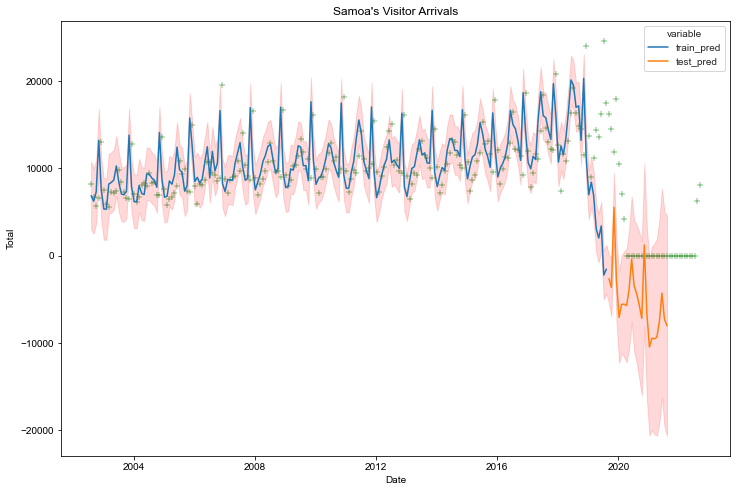

In [17]:
viz_df = samoa_stats[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
viz_df["Date"] = pd.to_datetime(viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=samoa_stats, color="green", marker="+")
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.15, color="red", data=samoa_stats)
sns.lineplot(data=viz_df, x="Date", y="value", hue="variable")
plt.title("Samoa's Visitor Arrivals")